# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
# data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

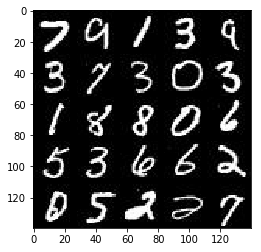

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

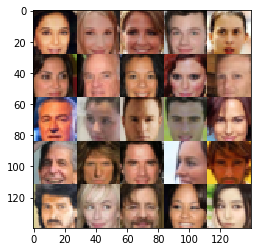

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    input_real = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels),
                                name='input_real')
    input_z = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    learning_rate = tf.placeholder(tf.float32, name='learning_rate')

    return input_real, input_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    alpha = 0.2
    with tf.variable_scope('discriminator', reuse=reuse):
        # Input layer is 28x28x3
        x1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same',
                              kernel_initializer=tf.contrib.layers.xavier_initializer())
        x1 = tf.maximum(alpha * x1, x1)
        x1 = tf.nn.dropout(x1, 0.7)
        # 14x14x64
        
        x2 = tf.layers.conv2d(x1, 128, 5, strides=1, padding="same",
                              kernel_initializer=tf.contrib.layers.xavier_initializer())
        x2 = tf.layers.batch_normalization(x2, training=True)
        x2 = tf.maximum(alpha*x2, x2)
        x2 = tf.nn.dropout(x2, 0.7)
        # 14x14x128
        
        x3 = tf.layers.conv2d(x2, 256, 5, strides=2, padding="same",
                              kernel_initializer=tf.contrib.layers.xavier_initializer())
        x3 = tf.layers.batch_normalization(x3, training=True)
        x3 = tf.maximum(alpha*x3, x3)
        x3 = tf.nn.dropout(x3, 0.7)
        # 7x7x256
        
        x4 = tf.layers.conv2d(x3, 512, 5, strides=1, padding="same",
                              kernel_initializer=tf.contrib.layers.xavier_initializer())
        x4 = tf.layers.batch_normalization(x4, training=True)
        x4 = tf.maximum(alpha*x4, x4)
        x4 = tf.nn.dropout(x4, 0.7)
        # 7x7x512
        
        # Flatten
        flat = tf.reshape(x4, (-1, 7*7*512))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
        return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    alpha = 0.2
    with tf.variable_scope("generator", reuse=not is_train):
        x1 = tf.layers.dense(z, 7*7*1024)
        x1 = tf.reshape(x1, (-1, 7, 7, 1024))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha * x1, x1)
        x1 = tf.nn.dropout(x1, 0.8)
        # 7x7x1024
        
        x2 = tf.layers.conv2d_transpose(x1, 512, 5, strides=1, padding='same',
                                        kernel_initializer=tf.contrib.layers.xavier_initializer())
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha * x2, x2)
        x2 = tf.nn.dropout(x2, 0.8)
        # 7x7x512 now
        
        x3 = tf.layers.conv2d_transpose(x2, 256, 5, strides=2, padding='same',
                                        kernel_initializer=tf.contrib.layers.xavier_initializer())
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(alpha * x3, x3)
        x3 = tf.nn.dropout(x3, 0.8)
        # 14x14x256 now
        
        x4 = tf.layers.conv2d_transpose(x3, 128, 5, strides=1, padding='same',
                                        kernel_initializer=tf.contrib.layers.xavier_initializer())
        x4 = tf.layers.batch_normalization(x4, training=is_train)
        x4 = tf.maximum(alpha * x4, x4)
        x4 = tf.nn.dropout(x4, 0.8)
        # 14x14x128 now
        
        # Output layer
        logits = tf.layers.conv2d_transpose(x4, out_channel_dim, 5, strides=2, padding='same')
        # 28x28x3 now
    
        out = tf.tanh(logits)
        
        return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)*0.9))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake

    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS, scope='generator')):
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [11]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    input_real, input_z, input_lr = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, data_shape[3])
    d_opt, g_opt = model_opt(d_loss, g_loss, input_lr, beta1)
    steps = 0
    
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                steps += 1
                # Resize images ( -1 to 1)
                batch_images = batch_images * 2
                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                # Run optimizers
                _ = sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z, input_lr: learning_rate})
                _ = sess.run(g_opt, feed_dict={input_real: batch_images, input_z: batch_z, input_lr: learning_rate})
                
                if steps % 10 == 0 or steps == 1:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i+1, epochs),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))

                if steps % 100 == 0 or steps == 1:
                    show_generator_output(sess, 20, input_z, data_shape[3], data_image_mode)
        show_generator_output(sess, 20, input_z, data_shape[3], data_image_mode)
        print("Done");
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 2.2224... Generator Loss: 0.2778


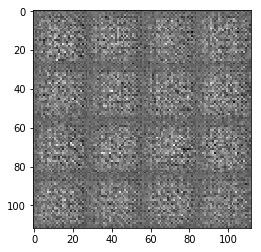

Epoch 1/2... Discriminator Loss: 1.1759... Generator Loss: 0.9101
Epoch 1/2... Discriminator Loss: 5.5569... Generator Loss: 0.0160
Epoch 1/2... Discriminator Loss: 1.4278... Generator Loss: 3.8287
Epoch 1/2... Discriminator Loss: 2.6373... Generator Loss: 4.3695
Epoch 1/2... Discriminator Loss: 1.0476... Generator Loss: 2.8159
Epoch 1/2... Discriminator Loss: 0.9285... Generator Loss: 1.7430
Epoch 1/2... Discriminator Loss: 5.2686... Generator Loss: 6.7850
Epoch 1/2... Discriminator Loss: 1.8597... Generator Loss: 1.3262
Epoch 1/2... Discriminator Loss: 1.2227... Generator Loss: 1.5393
Epoch 1/2... Discriminator Loss: 1.2291... Generator Loss: 1.0768


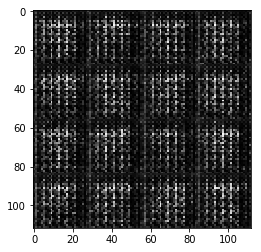

Epoch 1/2... Discriminator Loss: 1.4368... Generator Loss: 1.5523
Epoch 1/2... Discriminator Loss: 0.5769... Generator Loss: 3.9496
Epoch 1/2... Discriminator Loss: 2.1145... Generator Loss: 0.8389
Epoch 1/2... Discriminator Loss: 1.8507... Generator Loss: 2.2372
Epoch 1/2... Discriminator Loss: 0.8667... Generator Loss: 2.4875
Epoch 1/2... Discriminator Loss: 0.8502... Generator Loss: 2.1435
Epoch 1/2... Discriminator Loss: 1.6909... Generator Loss: 3.4453
Epoch 1/2... Discriminator Loss: 1.1610... Generator Loss: 2.4649
Epoch 1/2... Discriminator Loss: 1.1084... Generator Loss: 1.2891
Epoch 1/2... Discriminator Loss: 1.7533... Generator Loss: 0.9340


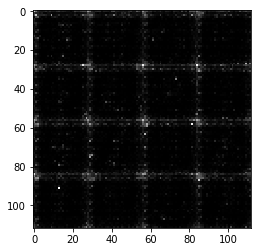

Epoch 1/2... Discriminator Loss: 2.1083... Generator Loss: 1.2951
Epoch 1/2... Discriminator Loss: 1.7355... Generator Loss: 2.0818
Epoch 1/2... Discriminator Loss: 1.7755... Generator Loss: 0.9409
Epoch 1/2... Discriminator Loss: 1.2458... Generator Loss: 1.7613
Epoch 1/2... Discriminator Loss: 1.1393... Generator Loss: 1.8393
Epoch 1/2... Discriminator Loss: 0.8834... Generator Loss: 2.5946
Epoch 1/2... Discriminator Loss: 1.1214... Generator Loss: 1.4855
Epoch 1/2... Discriminator Loss: 1.2054... Generator Loss: 1.3170
Epoch 1/2... Discriminator Loss: 1.5185... Generator Loss: 1.8554
Epoch 1/2... Discriminator Loss: 1.4594... Generator Loss: 1.8969


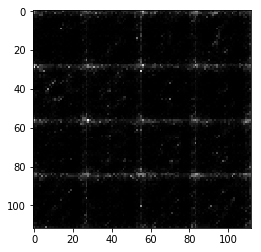

Epoch 1/2... Discriminator Loss: 1.5179... Generator Loss: 1.3608
Epoch 1/2... Discriminator Loss: 1.6521... Generator Loss: 0.9661
Epoch 1/2... Discriminator Loss: 1.0807... Generator Loss: 1.4330
Epoch 1/2... Discriminator Loss: 1.2855... Generator Loss: 1.7859
Epoch 1/2... Discriminator Loss: 1.3591... Generator Loss: 0.8544
Epoch 1/2... Discriminator Loss: 1.8213... Generator Loss: 0.6420
Epoch 1/2... Discriminator Loss: 1.2583... Generator Loss: 0.9870
Epoch 1/2... Discriminator Loss: 1.3584... Generator Loss: 2.1112
Epoch 1/2... Discriminator Loss: 1.7696... Generator Loss: 2.0862
Epoch 1/2... Discriminator Loss: 1.3421... Generator Loss: 1.1850


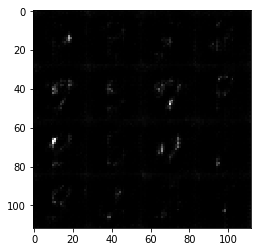

Epoch 1/2... Discriminator Loss: 1.2857... Generator Loss: 1.9932
Epoch 1/2... Discriminator Loss: 1.3795... Generator Loss: 0.6697
Epoch 1/2... Discriminator Loss: 1.3001... Generator Loss: 0.8022
Epoch 1/2... Discriminator Loss: 1.0931... Generator Loss: 1.5057
Epoch 1/2... Discriminator Loss: 1.3087... Generator Loss: 1.2132
Epoch 1/2... Discriminator Loss: 1.3241... Generator Loss: 1.4732
Epoch 1/2... Discriminator Loss: 1.6521... Generator Loss: 0.9193
Epoch 1/2... Discriminator Loss: 1.6196... Generator Loss: 0.4694
Epoch 1/2... Discriminator Loss: 1.4742... Generator Loss: 0.6900
Epoch 1/2... Discriminator Loss: 1.2872... Generator Loss: 0.9520


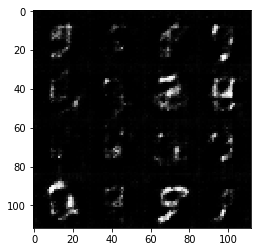

Epoch 1/2... Discriminator Loss: 1.4170... Generator Loss: 1.2094
Epoch 1/2... Discriminator Loss: 1.1902... Generator Loss: 1.6107
Epoch 1/2... Discriminator Loss: 1.4307... Generator Loss: 1.7508
Epoch 1/2... Discriminator Loss: 1.4348... Generator Loss: 1.3957
Epoch 1/2... Discriminator Loss: 1.8394... Generator Loss: 2.1476
Epoch 1/2... Discriminator Loss: 1.3327... Generator Loss: 1.3729
Epoch 1/2... Discriminator Loss: 1.6954... Generator Loss: 2.0487
Epoch 1/2... Discriminator Loss: 1.3271... Generator Loss: 0.6282
Epoch 1/2... Discriminator Loss: 1.5868... Generator Loss: 1.3353
Epoch 1/2... Discriminator Loss: 1.3529... Generator Loss: 0.9805


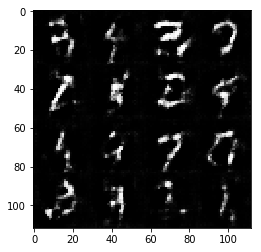

Epoch 1/2... Discriminator Loss: 1.2750... Generator Loss: 0.7636
Epoch 1/2... Discriminator Loss: 1.7732... Generator Loss: 1.0769
Epoch 1/2... Discriminator Loss: 1.2611... Generator Loss: 1.0071
Epoch 1/2... Discriminator Loss: 1.3145... Generator Loss: 0.8405
Epoch 1/2... Discriminator Loss: 1.3385... Generator Loss: 0.6612
Epoch 1/2... Discriminator Loss: 1.1283... Generator Loss: 1.4099
Epoch 1/2... Discriminator Loss: 1.2616... Generator Loss: 1.2543
Epoch 1/2... Discriminator Loss: 1.4224... Generator Loss: 1.2816
Epoch 1/2... Discriminator Loss: 1.2894... Generator Loss: 1.2359
Epoch 1/2... Discriminator Loss: 1.5494... Generator Loss: 0.8665


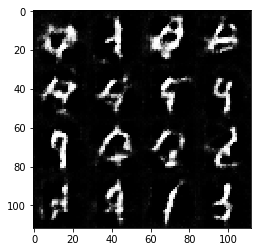

Epoch 1/2... Discriminator Loss: 1.4528... Generator Loss: 0.9812
Epoch 1/2... Discriminator Loss: 1.2952... Generator Loss: 0.9940
Epoch 1/2... Discriminator Loss: 1.5635... Generator Loss: 2.0593
Epoch 1/2... Discriminator Loss: 1.2961... Generator Loss: 0.9880
Epoch 1/2... Discriminator Loss: 1.4291... Generator Loss: 0.6218
Epoch 1/2... Discriminator Loss: 1.1322... Generator Loss: 1.0249
Epoch 1/2... Discriminator Loss: 1.4027... Generator Loss: 1.7658
Epoch 1/2... Discriminator Loss: 1.3045... Generator Loss: 1.2216
Epoch 1/2... Discriminator Loss: 1.4099... Generator Loss: 0.7546
Epoch 1/2... Discriminator Loss: 2.0094... Generator Loss: 2.0798


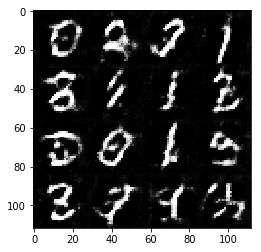

Epoch 1/2... Discriminator Loss: 1.3605... Generator Loss: 0.8885
Epoch 1/2... Discriminator Loss: 1.4403... Generator Loss: 0.9715
Epoch 1/2... Discriminator Loss: 1.4269... Generator Loss: 0.7470
Epoch 1/2... Discriminator Loss: 1.3462... Generator Loss: 1.0956
Epoch 1/2... Discriminator Loss: 1.4494... Generator Loss: 0.8048
Epoch 1/2... Discriminator Loss: 1.6195... Generator Loss: 0.5918
Epoch 1/2... Discriminator Loss: 1.5837... Generator Loss: 0.4660
Epoch 1/2... Discriminator Loss: 1.3927... Generator Loss: 0.7657
Epoch 1/2... Discriminator Loss: 1.3273... Generator Loss: 0.8193
Epoch 1/2... Discriminator Loss: 1.2036... Generator Loss: 0.9534


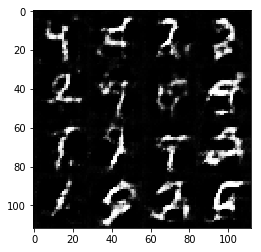

Epoch 1/2... Discriminator Loss: 1.2805... Generator Loss: 1.0566
Epoch 1/2... Discriminator Loss: 1.1696... Generator Loss: 1.0554
Epoch 1/2... Discriminator Loss: 1.6016... Generator Loss: 2.0178
Epoch 1/2... Discriminator Loss: 1.0904... Generator Loss: 0.8553
Epoch 1/2... Discriminator Loss: 1.5460... Generator Loss: 0.6682
Epoch 1/2... Discriminator Loss: 1.2586... Generator Loss: 0.9014
Epoch 1/2... Discriminator Loss: 1.2235... Generator Loss: 0.8271
Epoch 1/2... Discriminator Loss: 1.3409... Generator Loss: 1.1813
Epoch 1/2... Discriminator Loss: 1.4819... Generator Loss: 1.0370
Epoch 1/2... Discriminator Loss: 1.6389... Generator Loss: 0.4921


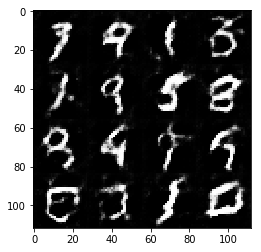

Epoch 1/2... Discriminator Loss: 1.4403... Generator Loss: 1.7952
Epoch 1/2... Discriminator Loss: 1.4454... Generator Loss: 1.4138
Epoch 1/2... Discriminator Loss: 1.4682... Generator Loss: 0.7470
Epoch 1/2... Discriminator Loss: 1.1956... Generator Loss: 0.6942
Epoch 1/2... Discriminator Loss: 1.4063... Generator Loss: 0.8310
Epoch 1/2... Discriminator Loss: 1.2576... Generator Loss: 1.1483
Epoch 1/2... Discriminator Loss: 1.3928... Generator Loss: 0.6934
Epoch 1/2... Discriminator Loss: 1.5890... Generator Loss: 1.1174
Epoch 1/2... Discriminator Loss: 1.2928... Generator Loss: 1.1354
Epoch 1/2... Discriminator Loss: 1.4783... Generator Loss: 1.2971


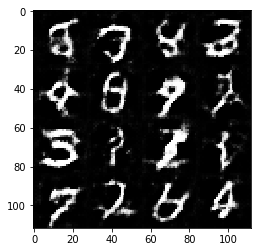

Epoch 1/2... Discriminator Loss: 1.2039... Generator Loss: 0.8641
Epoch 1/2... Discriminator Loss: 1.2039... Generator Loss: 0.7231
Epoch 1/2... Discriminator Loss: 1.3689... Generator Loss: 0.5885
Epoch 1/2... Discriminator Loss: 1.2730... Generator Loss: 1.6704
Epoch 1/2... Discriminator Loss: 1.5033... Generator Loss: 1.7876
Epoch 1/2... Discriminator Loss: 1.4692... Generator Loss: 0.9676
Epoch 1/2... Discriminator Loss: 1.3009... Generator Loss: 0.9784
Epoch 1/2... Discriminator Loss: 1.2756... Generator Loss: 0.8791
Epoch 1/2... Discriminator Loss: 1.3288... Generator Loss: 0.9365
Epoch 1/2... Discriminator Loss: 1.4323... Generator Loss: 1.4524


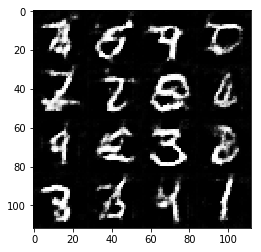

Epoch 1/2... Discriminator Loss: 1.3689... Generator Loss: 1.4969
Epoch 1/2... Discriminator Loss: 1.4609... Generator Loss: 0.6106
Epoch 1/2... Discriminator Loss: 1.2231... Generator Loss: 1.7110
Epoch 1/2... Discriminator Loss: 1.1609... Generator Loss: 1.4192
Epoch 1/2... Discriminator Loss: 1.4401... Generator Loss: 0.7321
Epoch 1/2... Discriminator Loss: 1.2857... Generator Loss: 0.7085
Epoch 1/2... Discriminator Loss: 1.3064... Generator Loss: 1.0805
Epoch 1/2... Discriminator Loss: 1.3408... Generator Loss: 1.6833
Epoch 1/2... Discriminator Loss: 1.6430... Generator Loss: 0.5438
Epoch 1/2... Discriminator Loss: 1.5891... Generator Loss: 2.4262


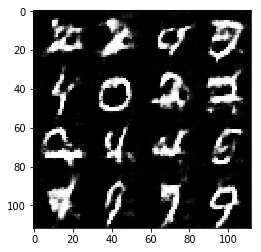

Epoch 1/2... Discriminator Loss: 1.6251... Generator Loss: 0.4844
Epoch 1/2... Discriminator Loss: 1.2924... Generator Loss: 0.9065
Epoch 1/2... Discriminator Loss: 1.4678... Generator Loss: 0.5338
Epoch 1/2... Discriminator Loss: 1.2478... Generator Loss: 0.9537
Epoch 1/2... Discriminator Loss: 1.4329... Generator Loss: 0.6496
Epoch 1/2... Discriminator Loss: 1.5112... Generator Loss: 0.8307
Epoch 1/2... Discriminator Loss: 1.1473... Generator Loss: 1.8321
Epoch 1/2... Discriminator Loss: 1.3323... Generator Loss: 1.9199
Epoch 1/2... Discriminator Loss: 1.3485... Generator Loss: 0.9820
Epoch 1/2... Discriminator Loss: 1.2767... Generator Loss: 1.1675


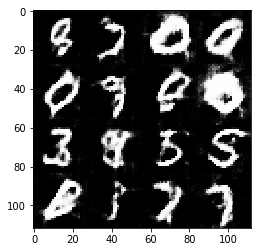

Epoch 1/2... Discriminator Loss: 1.3661... Generator Loss: 1.7509
Epoch 1/2... Discriminator Loss: 1.1840... Generator Loss: 1.0553
Epoch 1/2... Discriminator Loss: 1.1263... Generator Loss: 1.0612
Epoch 1/2... Discriminator Loss: 1.4167... Generator Loss: 1.0305
Epoch 1/2... Discriminator Loss: 1.1430... Generator Loss: 0.7894
Epoch 1/2... Discriminator Loss: 1.2449... Generator Loss: 1.1752
Epoch 1/2... Discriminator Loss: 1.5774... Generator Loss: 2.3838
Epoch 1/2... Discriminator Loss: 1.4006... Generator Loss: 0.8247
Epoch 1/2... Discriminator Loss: 1.4241... Generator Loss: 1.8216
Epoch 1/2... Discriminator Loss: 1.2754... Generator Loss: 1.0201


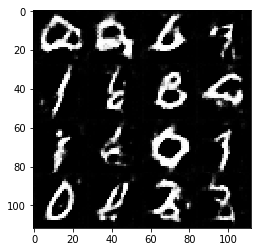

Epoch 1/2... Discriminator Loss: 1.2729... Generator Loss: 1.4897
Epoch 1/2... Discriminator Loss: 1.1686... Generator Loss: 1.2944
Epoch 1/2... Discriminator Loss: 1.3783... Generator Loss: 0.9122
Epoch 1/2... Discriminator Loss: 1.4006... Generator Loss: 2.3744
Epoch 1/2... Discriminator Loss: 1.1143... Generator Loss: 1.1961
Epoch 1/2... Discriminator Loss: 1.6762... Generator Loss: 2.1975
Epoch 1/2... Discriminator Loss: 1.0602... Generator Loss: 0.7684
Epoch 1/2... Discriminator Loss: 1.3416... Generator Loss: 1.1733
Epoch 1/2... Discriminator Loss: 1.2128... Generator Loss: 0.9880
Epoch 1/2... Discriminator Loss: 1.1514... Generator Loss: 1.4125


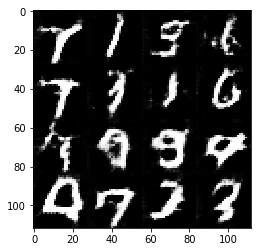

Epoch 1/2... Discriminator Loss: 1.4208... Generator Loss: 0.6724
Epoch 1/2... Discriminator Loss: 1.1343... Generator Loss: 1.2614
Epoch 1/2... Discriminator Loss: 1.2900... Generator Loss: 0.7461
Epoch 1/2... Discriminator Loss: 1.2135... Generator Loss: 1.0213
Epoch 1/2... Discriminator Loss: 1.1485... Generator Loss: 0.9449
Epoch 1/2... Discriminator Loss: 1.6432... Generator Loss: 0.4292
Epoch 1/2... Discriminator Loss: 1.2210... Generator Loss: 0.9293
Epoch 1/2... Discriminator Loss: 1.1828... Generator Loss: 1.4484
Epoch 1/2... Discriminator Loss: 1.3176... Generator Loss: 1.0878
Epoch 1/2... Discriminator Loss: 1.2721... Generator Loss: 0.7083


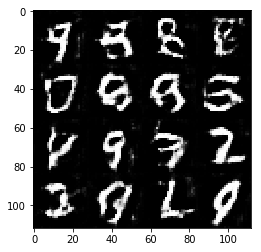

Epoch 1/2... Discriminator Loss: 1.6256... Generator Loss: 1.8916
Epoch 1/2... Discriminator Loss: 1.1013... Generator Loss: 1.3574
Epoch 1/2... Discriminator Loss: 1.2850... Generator Loss: 0.8611
Epoch 1/2... Discriminator Loss: 1.0557... Generator Loss: 1.0731
Epoch 1/2... Discriminator Loss: 1.6414... Generator Loss: 0.4968
Epoch 1/2... Discriminator Loss: 1.4711... Generator Loss: 0.4640
Epoch 1/2... Discriminator Loss: 1.0851... Generator Loss: 1.0009
Epoch 1/2... Discriminator Loss: 1.0336... Generator Loss: 1.1080
Epoch 1/2... Discriminator Loss: 0.9996... Generator Loss: 1.6329
Epoch 1/2... Discriminator Loss: 1.5822... Generator Loss: 2.3750


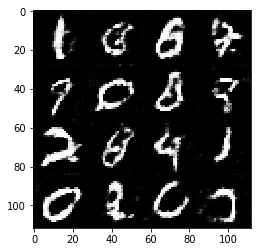

Epoch 1/2... Discriminator Loss: 1.5069... Generator Loss: 2.1620
Epoch 1/2... Discriminator Loss: 1.3419... Generator Loss: 0.9319
Epoch 1/2... Discriminator Loss: 1.0503... Generator Loss: 1.5645
Epoch 1/2... Discriminator Loss: 1.2870... Generator Loss: 1.0742
Epoch 1/2... Discriminator Loss: 1.1857... Generator Loss: 0.6795
Epoch 1/2... Discriminator Loss: 1.2603... Generator Loss: 0.6855
Epoch 1/2... Discriminator Loss: 1.4575... Generator Loss: 2.6138
Epoch 2/2... Discriminator Loss: 1.1334... Generator Loss: 1.0781
Epoch 2/2... Discriminator Loss: 1.1673... Generator Loss: 1.5504
Epoch 2/2... Discriminator Loss: 1.0884... Generator Loss: 1.4856


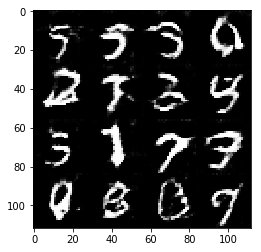

Epoch 2/2... Discriminator Loss: 1.1528... Generator Loss: 1.1625
Epoch 2/2... Discriminator Loss: 0.7552... Generator Loss: 1.3165
Epoch 2/2... Discriminator Loss: 1.0120... Generator Loss: 2.1424
Epoch 2/2... Discriminator Loss: 0.9918... Generator Loss: 2.1286
Epoch 2/2... Discriminator Loss: 1.2586... Generator Loss: 1.6327
Epoch 2/2... Discriminator Loss: 1.3893... Generator Loss: 0.9077
Epoch 2/2... Discriminator Loss: 1.1036... Generator Loss: 1.3610
Epoch 2/2... Discriminator Loss: 1.3166... Generator Loss: 1.2355
Epoch 2/2... Discriminator Loss: 1.3728... Generator Loss: 0.6257
Epoch 2/2... Discriminator Loss: 1.3044... Generator Loss: 1.2462


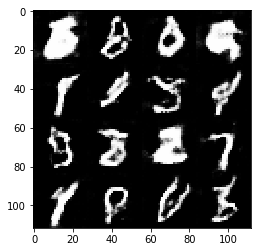

Epoch 2/2... Discriminator Loss: 1.3026... Generator Loss: 1.0433
Epoch 2/2... Discriminator Loss: 1.6460... Generator Loss: 2.4905
Epoch 2/2... Discriminator Loss: 0.9695... Generator Loss: 1.8315
Epoch 2/2... Discriminator Loss: 1.4466... Generator Loss: 3.1358
Epoch 2/2... Discriminator Loss: 1.3253... Generator Loss: 0.5940
Epoch 2/2... Discriminator Loss: 1.1270... Generator Loss: 0.9949
Epoch 2/2... Discriminator Loss: 1.2837... Generator Loss: 1.1577
Epoch 2/2... Discriminator Loss: 1.2064... Generator Loss: 0.6236
Epoch 2/2... Discriminator Loss: 1.0552... Generator Loss: 1.2814
Epoch 2/2... Discriminator Loss: 1.1331... Generator Loss: 1.0622


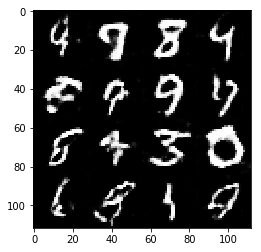

Epoch 2/2... Discriminator Loss: 0.9222... Generator Loss: 1.6265
Epoch 2/2... Discriminator Loss: 1.6583... Generator Loss: 0.6358
Epoch 2/2... Discriminator Loss: 0.9454... Generator Loss: 1.4632
Epoch 2/2... Discriminator Loss: 1.4714... Generator Loss: 0.8518
Epoch 2/2... Discriminator Loss: 1.1432... Generator Loss: 1.0030
Epoch 2/2... Discriminator Loss: 1.0778... Generator Loss: 1.1549
Epoch 2/2... Discriminator Loss: 1.2618... Generator Loss: 2.0110
Epoch 2/2... Discriminator Loss: 1.1465... Generator Loss: 2.1522
Epoch 2/2... Discriminator Loss: 1.1938... Generator Loss: 2.1156
Epoch 2/2... Discriminator Loss: 0.9128... Generator Loss: 1.3839


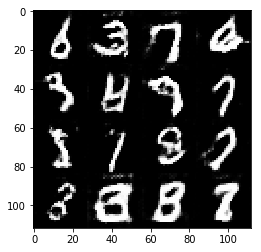

Epoch 2/2... Discriminator Loss: 1.0713... Generator Loss: 1.9694
Epoch 2/2... Discriminator Loss: 0.8774... Generator Loss: 1.2241
Epoch 2/2... Discriminator Loss: 1.1852... Generator Loss: 1.6337
Epoch 2/2... Discriminator Loss: 0.9988... Generator Loss: 1.7100
Epoch 2/2... Discriminator Loss: 1.0746... Generator Loss: 1.0649
Epoch 2/2... Discriminator Loss: 1.0239... Generator Loss: 1.7281
Epoch 2/2... Discriminator Loss: 1.1083... Generator Loss: 0.8638
Epoch 2/2... Discriminator Loss: 1.7313... Generator Loss: 3.4606
Epoch 2/2... Discriminator Loss: 0.8675... Generator Loss: 1.3067
Epoch 2/2... Discriminator Loss: 1.4146... Generator Loss: 0.5693


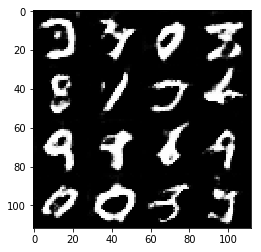

Epoch 2/2... Discriminator Loss: 1.0055... Generator Loss: 2.2524
Epoch 2/2... Discriminator Loss: 1.1125... Generator Loss: 0.8644
Epoch 2/2... Discriminator Loss: 1.3290... Generator Loss: 1.6544
Epoch 2/2... Discriminator Loss: 0.9610... Generator Loss: 1.3163
Epoch 2/2... Discriminator Loss: 1.1589... Generator Loss: 1.0228
Epoch 2/2... Discriminator Loss: 1.4040... Generator Loss: 1.0199
Epoch 2/2... Discriminator Loss: 1.0941... Generator Loss: 2.0348
Epoch 2/2... Discriminator Loss: 0.9055... Generator Loss: 1.7034
Epoch 2/2... Discriminator Loss: 1.2123... Generator Loss: 0.9487
Epoch 2/2... Discriminator Loss: 1.0843... Generator Loss: 1.4964


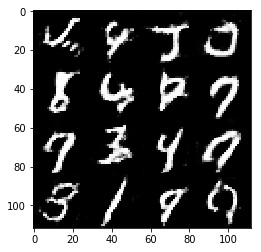

Epoch 2/2... Discriminator Loss: 0.9951... Generator Loss: 0.8797
Epoch 2/2... Discriminator Loss: 1.1669... Generator Loss: 1.7080
Epoch 2/2... Discriminator Loss: 1.1237... Generator Loss: 1.1025
Epoch 2/2... Discriminator Loss: 0.9965... Generator Loss: 1.2294
Epoch 2/2... Discriminator Loss: 0.8976... Generator Loss: 1.5448
Epoch 2/2... Discriminator Loss: 1.6555... Generator Loss: 0.4081
Epoch 2/2... Discriminator Loss: 0.7009... Generator Loss: 1.7380
Epoch 2/2... Discriminator Loss: 0.8880... Generator Loss: 2.5245
Epoch 2/2... Discriminator Loss: 1.0644... Generator Loss: 1.0778
Epoch 2/2... Discriminator Loss: 1.1374... Generator Loss: 0.9998


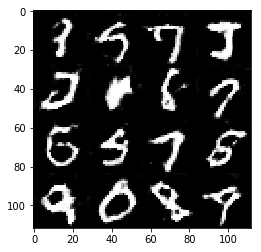

Epoch 2/2... Discriminator Loss: 1.5239... Generator Loss: 2.6434
Epoch 2/2... Discriminator Loss: 1.0283... Generator Loss: 1.1332
Epoch 2/2... Discriminator Loss: 1.1446... Generator Loss: 1.0038
Epoch 2/2... Discriminator Loss: 0.9570... Generator Loss: 0.8665
Epoch 2/2... Discriminator Loss: 1.3290... Generator Loss: 1.1012
Epoch 2/2... Discriminator Loss: 0.9050... Generator Loss: 1.4920
Epoch 2/2... Discriminator Loss: 0.6225... Generator Loss: 1.8343
Epoch 2/2... Discriminator Loss: 0.8949... Generator Loss: 1.0886
Epoch 2/2... Discriminator Loss: 1.1017... Generator Loss: 2.1585
Epoch 2/2... Discriminator Loss: 1.3349... Generator Loss: 0.9997


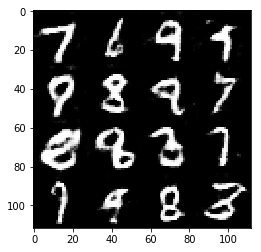

Epoch 2/2... Discriminator Loss: 1.0518... Generator Loss: 1.2446
Epoch 2/2... Discriminator Loss: 0.9552... Generator Loss: 1.6294
Epoch 2/2... Discriminator Loss: 1.1467... Generator Loss: 1.9945
Epoch 2/2... Discriminator Loss: 0.9967... Generator Loss: 1.2014
Epoch 2/2... Discriminator Loss: 2.6235... Generator Loss: 3.5535
Epoch 2/2... Discriminator Loss: 1.0061... Generator Loss: 1.1059
Epoch 2/2... Discriminator Loss: 1.3051... Generator Loss: 0.7270
Epoch 2/2... Discriminator Loss: 0.9007... Generator Loss: 1.6423
Epoch 2/2... Discriminator Loss: 0.8560... Generator Loss: 1.6975
Epoch 2/2... Discriminator Loss: 0.6921... Generator Loss: 1.8721


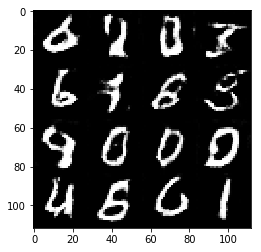

Epoch 2/2... Discriminator Loss: 0.7859... Generator Loss: 1.1865
Epoch 2/2... Discriminator Loss: 0.8505... Generator Loss: 2.5942
Epoch 2/2... Discriminator Loss: 0.9460... Generator Loss: 1.3216
Epoch 2/2... Discriminator Loss: 1.1980... Generator Loss: 0.3806
Epoch 2/2... Discriminator Loss: 1.0669... Generator Loss: 1.8898
Epoch 2/2... Discriminator Loss: 0.8268... Generator Loss: 1.5215
Epoch 2/2... Discriminator Loss: 1.0820... Generator Loss: 3.1537
Epoch 2/2... Discriminator Loss: 0.8526... Generator Loss: 1.2436
Epoch 2/2... Discriminator Loss: 0.8044... Generator Loss: 2.1108
Epoch 2/2... Discriminator Loss: 0.8619... Generator Loss: 1.5948


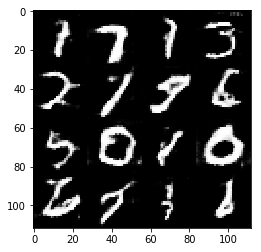

Epoch 2/2... Discriminator Loss: 1.0685... Generator Loss: 2.8228
Epoch 2/2... Discriminator Loss: 0.8734... Generator Loss: 3.1650
Epoch 2/2... Discriminator Loss: 1.3408... Generator Loss: 0.5135
Epoch 2/2... Discriminator Loss: 0.9831... Generator Loss: 1.1382
Epoch 2/2... Discriminator Loss: 0.7149... Generator Loss: 1.4833
Epoch 2/2... Discriminator Loss: 1.0506... Generator Loss: 0.9359
Epoch 2/2... Discriminator Loss: 0.9633... Generator Loss: 1.2842
Epoch 2/2... Discriminator Loss: 1.6332... Generator Loss: 0.6543
Epoch 2/2... Discriminator Loss: 0.9754... Generator Loss: 1.0399
Epoch 2/2... Discriminator Loss: 1.2836... Generator Loss: 1.2322


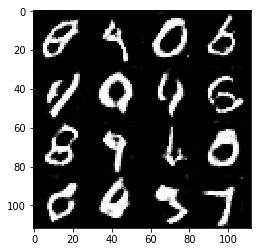

Epoch 2/2... Discriminator Loss: 1.0958... Generator Loss: 0.5996
Epoch 2/2... Discriminator Loss: 0.7933... Generator Loss: 1.9786
Epoch 2/2... Discriminator Loss: 1.1374... Generator Loss: 0.7517
Epoch 2/2... Discriminator Loss: 0.9695... Generator Loss: 1.3199
Epoch 2/2... Discriminator Loss: 1.1864... Generator Loss: 1.4823
Epoch 2/2... Discriminator Loss: 0.7058... Generator Loss: 1.7738
Epoch 2/2... Discriminator Loss: 0.6947... Generator Loss: 1.9857
Epoch 2/2... Discriminator Loss: 1.6355... Generator Loss: 0.7094
Epoch 2/2... Discriminator Loss: 0.9238... Generator Loss: 1.3529
Epoch 2/2... Discriminator Loss: 1.1529... Generator Loss: 0.7869


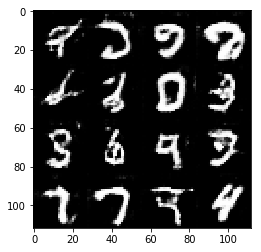

Epoch 2/2... Discriminator Loss: 0.8277... Generator Loss: 1.7098
Epoch 2/2... Discriminator Loss: 1.0075... Generator Loss: 0.6043
Epoch 2/2... Discriminator Loss: 1.0791... Generator Loss: 1.3475
Epoch 2/2... Discriminator Loss: 1.2493... Generator Loss: 1.7783
Epoch 2/2... Discriminator Loss: 0.8991... Generator Loss: 1.3859
Epoch 2/2... Discriminator Loss: 1.0980... Generator Loss: 1.7174
Epoch 2/2... Discriminator Loss: 1.2810... Generator Loss: 1.2265
Epoch 2/2... Discriminator Loss: 1.0008... Generator Loss: 0.9671
Epoch 2/2... Discriminator Loss: 1.0349... Generator Loss: 0.8262
Epoch 2/2... Discriminator Loss: 0.9771... Generator Loss: 1.3184


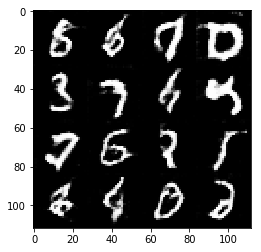

Epoch 2/2... Discriminator Loss: 0.8065... Generator Loss: 1.9478
Epoch 2/2... Discriminator Loss: 1.0094... Generator Loss: 0.6809
Epoch 2/2... Discriminator Loss: 0.7627... Generator Loss: 1.4635
Epoch 2/2... Discriminator Loss: 0.8960... Generator Loss: 2.4481
Epoch 2/2... Discriminator Loss: 1.7679... Generator Loss: 0.4803
Epoch 2/2... Discriminator Loss: 1.3206... Generator Loss: 2.5791
Epoch 2/2... Discriminator Loss: 0.8767... Generator Loss: 1.8794
Epoch 2/2... Discriminator Loss: 0.7526... Generator Loss: 1.3595
Epoch 2/2... Discriminator Loss: 0.9982... Generator Loss: 1.5738
Epoch 2/2... Discriminator Loss: 2.0304... Generator Loss: 2.9652


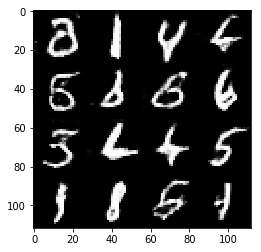

Epoch 2/2... Discriminator Loss: 1.1980... Generator Loss: 0.7685
Epoch 2/2... Discriminator Loss: 1.0403... Generator Loss: 2.9673
Epoch 2/2... Discriminator Loss: 1.2021... Generator Loss: 2.2150
Epoch 2/2... Discriminator Loss: 0.9396... Generator Loss: 2.2338
Epoch 2/2... Discriminator Loss: 0.9513... Generator Loss: 1.4718
Epoch 2/2... Discriminator Loss: 0.7673... Generator Loss: 1.6941
Epoch 2/2... Discriminator Loss: 0.7968... Generator Loss: 1.7983
Epoch 2/2... Discriminator Loss: 0.9380... Generator Loss: 2.8223
Epoch 2/2... Discriminator Loss: 1.0669... Generator Loss: 0.9535
Epoch 2/2... Discriminator Loss: 1.0276... Generator Loss: 1.4959


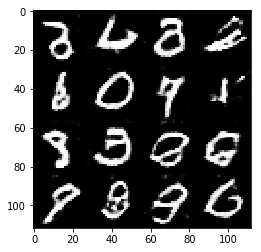

Epoch 2/2... Discriminator Loss: 1.9365... Generator Loss: 0.9947
Epoch 2/2... Discriminator Loss: 0.7148... Generator Loss: 1.7604
Epoch 2/2... Discriminator Loss: 0.9266... Generator Loss: 0.8499
Epoch 2/2... Discriminator Loss: 0.7702... Generator Loss: 1.4374
Epoch 2/2... Discriminator Loss: 0.8802... Generator Loss: 1.5166
Epoch 2/2... Discriminator Loss: 1.1268... Generator Loss: 2.7709
Epoch 2/2... Discriminator Loss: 0.8388... Generator Loss: 1.6556
Epoch 2/2... Discriminator Loss: 1.3200... Generator Loss: 0.7080
Epoch 2/2... Discriminator Loss: 0.7788... Generator Loss: 1.1815
Epoch 2/2... Discriminator Loss: 0.7148... Generator Loss: 2.6907


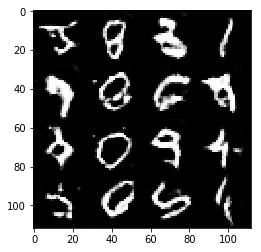

Epoch 2/2... Discriminator Loss: 1.3181... Generator Loss: 0.9722
Epoch 2/2... Discriminator Loss: 1.0674... Generator Loss: 1.7767
Epoch 2/2... Discriminator Loss: 1.0104... Generator Loss: 2.5337
Epoch 2/2... Discriminator Loss: 0.6933... Generator Loss: 2.2521
Epoch 2/2... Discriminator Loss: 1.1011... Generator Loss: 1.4101
Epoch 2/2... Discriminator Loss: 0.6585... Generator Loss: 2.6908
Epoch 2/2... Discriminator Loss: 1.4260... Generator Loss: 0.5740
Epoch 2/2... Discriminator Loss: 1.1346... Generator Loss: 1.0918
Epoch 2/2... Discriminator Loss: 0.7392... Generator Loss: 1.9203
Epoch 2/2... Discriminator Loss: 1.1748... Generator Loss: 1.1416


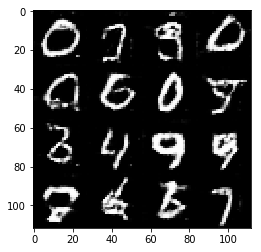

Epoch 2/2... Discriminator Loss: 0.9217... Generator Loss: 1.5251
Epoch 2/2... Discriminator Loss: 1.5983... Generator Loss: 0.5135
Epoch 2/2... Discriminator Loss: 1.0031... Generator Loss: 0.9867
Epoch 2/2... Discriminator Loss: 1.6994... Generator Loss: 0.8404
Epoch 2/2... Discriminator Loss: 1.0635... Generator Loss: 0.5272
Epoch 2/2... Discriminator Loss: 1.9947... Generator Loss: 3.1522
Epoch 2/2... Discriminator Loss: 0.6689... Generator Loss: 2.0491
Epoch 2/2... Discriminator Loss: 0.6432... Generator Loss: 3.1722
Epoch 2/2... Discriminator Loss: 0.6538... Generator Loss: 1.6588
Epoch 2/2... Discriminator Loss: 0.7502... Generator Loss: 1.9275


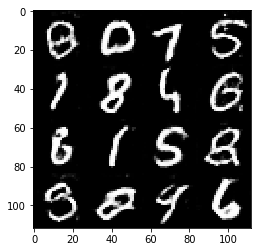

Epoch 2/2... Discriminator Loss: 0.8197... Generator Loss: 2.3074
Epoch 2/2... Discriminator Loss: 1.1616... Generator Loss: 1.0098
Epoch 2/2... Discriminator Loss: 1.0040... Generator Loss: 2.0238
Epoch 2/2... Discriminator Loss: 0.9332... Generator Loss: 2.6003
Epoch 2/2... Discriminator Loss: 1.0926... Generator Loss: 2.6004
Epoch 2/2... Discriminator Loss: 1.2482... Generator Loss: 1.3162
Epoch 2/2... Discriminator Loss: 0.9662... Generator Loss: 1.2175
Epoch 2/2... Discriminator Loss: 0.7081... Generator Loss: 2.0845
Epoch 2/2... Discriminator Loss: 0.6785... Generator Loss: 1.0455
Epoch 2/2... Discriminator Loss: 1.2146... Generator Loss: 0.9098


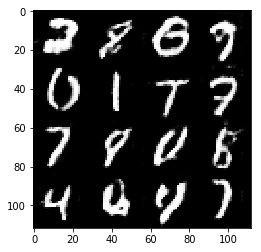

Epoch 2/2... Discriminator Loss: 0.8654... Generator Loss: 1.3236
Epoch 2/2... Discriminator Loss: 1.0168... Generator Loss: 1.9440
Epoch 2/2... Discriminator Loss: 0.8750... Generator Loss: 1.7892
Epoch 2/2... Discriminator Loss: 1.1234... Generator Loss: 2.6934
Epoch 2/2... Discriminator Loss: 1.1035... Generator Loss: 3.4547


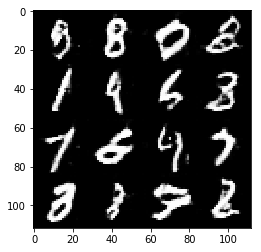

Done


In [14]:
batch_size = 32
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 2.4347... Generator Loss: 0.3147


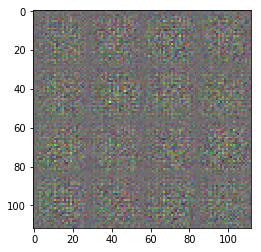

Epoch 1/1... Discriminator Loss: 0.8152... Generator Loss: 2.9241
Epoch 1/1... Discriminator Loss: 1.5671... Generator Loss: 2.9728
Epoch 1/1... Discriminator Loss: 2.6368... Generator Loss: 0.8861
Epoch 1/1... Discriminator Loss: 1.4842... Generator Loss: 1.7872
Epoch 1/1... Discriminator Loss: 5.3253... Generator Loss: 0.0580
Epoch 1/1... Discriminator Loss: 1.7363... Generator Loss: 3.6802
Epoch 1/1... Discriminator Loss: 2.6144... Generator Loss: 0.5112
Epoch 1/1... Discriminator Loss: 0.8531... Generator Loss: 3.9419
Epoch 1/1... Discriminator Loss: 2.9942... Generator Loss: 0.7493
Epoch 1/1... Discriminator Loss: 1.5280... Generator Loss: 2.3065


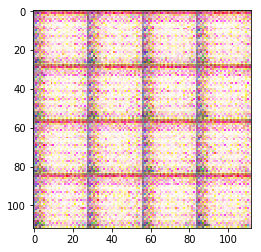

Epoch 1/1... Discriminator Loss: 1.1005... Generator Loss: 2.3028
Epoch 1/1... Discriminator Loss: 1.7909... Generator Loss: 1.7683
Epoch 1/1... Discriminator Loss: 0.9447... Generator Loss: 4.8770
Epoch 1/1... Discriminator Loss: 0.9033... Generator Loss: 2.7546
Epoch 1/1... Discriminator Loss: 0.6212... Generator Loss: 6.3186
Epoch 1/1... Discriminator Loss: 1.0261... Generator Loss: 1.8735
Epoch 1/1... Discriminator Loss: 1.1558... Generator Loss: 1.5604
Epoch 1/1... Discriminator Loss: 1.2854... Generator Loss: 1.7583
Epoch 1/1... Discriminator Loss: 0.7629... Generator Loss: 2.7519
Epoch 1/1... Discriminator Loss: 0.6404... Generator Loss: 1.9220


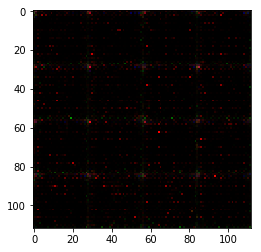

Epoch 1/1... Discriminator Loss: 0.7125... Generator Loss: 2.1460
Epoch 1/1... Discriminator Loss: 1.1325... Generator Loss: 1.4166
Epoch 1/1... Discriminator Loss: 0.8609... Generator Loss: 2.3160
Epoch 1/1... Discriminator Loss: 1.0813... Generator Loss: 3.3344
Epoch 1/1... Discriminator Loss: 1.1577... Generator Loss: 3.3100
Epoch 1/1... Discriminator Loss: 1.3904... Generator Loss: 0.8926
Epoch 1/1... Discriminator Loss: 1.2031... Generator Loss: 0.8860
Epoch 1/1... Discriminator Loss: 1.2173... Generator Loss: 2.1230
Epoch 1/1... Discriminator Loss: 0.8081... Generator Loss: 1.3584
Epoch 1/1... Discriminator Loss: 1.0899... Generator Loss: 1.4295


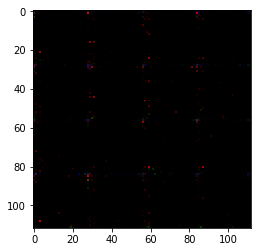

Epoch 1/1... Discriminator Loss: 0.9371... Generator Loss: 1.5098
Epoch 1/1... Discriminator Loss: 0.7638... Generator Loss: 1.4330
Epoch 1/1... Discriminator Loss: 1.5632... Generator Loss: 0.9986
Epoch 1/1... Discriminator Loss: 1.5195... Generator Loss: 0.8162
Epoch 1/1... Discriminator Loss: 1.2034... Generator Loss: 1.1042
Epoch 1/1... Discriminator Loss: 0.9297... Generator Loss: 1.8000
Epoch 1/1... Discriminator Loss: 0.7824... Generator Loss: 2.9201
Epoch 1/1... Discriminator Loss: 0.9655... Generator Loss: 1.5649
Epoch 1/1... Discriminator Loss: 1.7379... Generator Loss: 2.4865
Epoch 1/1... Discriminator Loss: 0.8266... Generator Loss: 1.8615


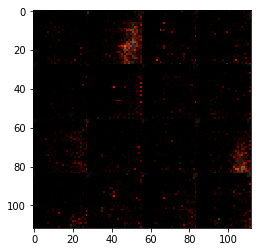

Epoch 1/1... Discriminator Loss: 1.3420... Generator Loss: 0.5363
Epoch 1/1... Discriminator Loss: 0.6604... Generator Loss: 2.6733
Epoch 1/1... Discriminator Loss: 1.0918... Generator Loss: 1.7253
Epoch 1/1... Discriminator Loss: 0.9541... Generator Loss: 2.1815
Epoch 1/1... Discriminator Loss: 1.1164... Generator Loss: 1.1144
Epoch 1/1... Discriminator Loss: 0.8635... Generator Loss: 2.0824
Epoch 1/1... Discriminator Loss: 1.4907... Generator Loss: 1.1090
Epoch 1/1... Discriminator Loss: 1.4849... Generator Loss: 2.5377
Epoch 1/1... Discriminator Loss: 1.0131... Generator Loss: 1.4615
Epoch 1/1... Discriminator Loss: 0.9811... Generator Loss: 1.3977


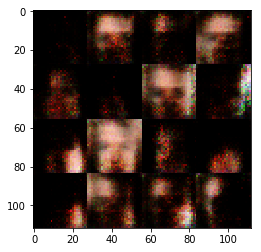

Epoch 1/1... Discriminator Loss: 0.8227... Generator Loss: 1.8196
Epoch 1/1... Discriminator Loss: 1.0447... Generator Loss: 2.1851
Epoch 1/1... Discriminator Loss: 0.8621... Generator Loss: 1.6871
Epoch 1/1... Discriminator Loss: 0.7148... Generator Loss: 2.8535
Epoch 1/1... Discriminator Loss: 0.8853... Generator Loss: 2.2459
Epoch 1/1... Discriminator Loss: 0.8789... Generator Loss: 2.4502
Epoch 1/1... Discriminator Loss: 0.9810... Generator Loss: 1.1688
Epoch 1/1... Discriminator Loss: 0.8325... Generator Loss: 1.2131
Epoch 1/1... Discriminator Loss: 0.7313... Generator Loss: 1.9889
Epoch 1/1... Discriminator Loss: 1.6993... Generator Loss: 0.8923


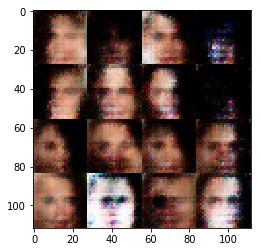

Epoch 1/1... Discriminator Loss: 1.0236... Generator Loss: 1.9495
Epoch 1/1... Discriminator Loss: 0.9236... Generator Loss: 1.1607
Epoch 1/1... Discriminator Loss: 1.8610... Generator Loss: 0.6492
Epoch 1/1... Discriminator Loss: 0.9773... Generator Loss: 2.6667
Epoch 1/1... Discriminator Loss: 0.6301... Generator Loss: 1.8784
Epoch 1/1... Discriminator Loss: 1.4996... Generator Loss: 0.5728
Epoch 1/1... Discriminator Loss: 1.2637... Generator Loss: 1.8597
Epoch 1/1... Discriminator Loss: 1.1470... Generator Loss: 0.8171
Epoch 1/1... Discriminator Loss: 1.4508... Generator Loss: 1.4069
Epoch 1/1... Discriminator Loss: 0.8757... Generator Loss: 2.5494


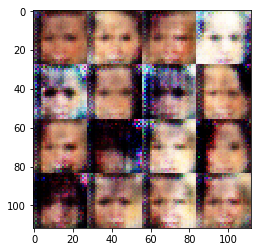

Epoch 1/1... Discriminator Loss: 1.2351... Generator Loss: 2.1487
Epoch 1/1... Discriminator Loss: 0.9745... Generator Loss: 1.4061
Epoch 1/1... Discriminator Loss: 1.6912... Generator Loss: 0.6194
Epoch 1/1... Discriminator Loss: 1.4257... Generator Loss: 2.1431
Epoch 1/1... Discriminator Loss: 0.9288... Generator Loss: 1.8383
Epoch 1/1... Discriminator Loss: 1.0546... Generator Loss: 0.7578
Epoch 1/1... Discriminator Loss: 1.1892... Generator Loss: 1.0671
Epoch 1/1... Discriminator Loss: 1.0776... Generator Loss: 1.4538
Epoch 1/1... Discriminator Loss: 1.2994... Generator Loss: 2.1031
Epoch 1/1... Discriminator Loss: 1.0011... Generator Loss: 1.3632


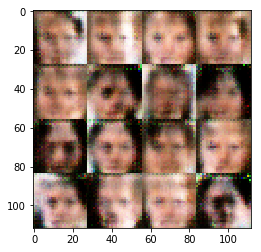

Epoch 1/1... Discriminator Loss: 1.0730... Generator Loss: 1.3197
Epoch 1/1... Discriminator Loss: 1.0662... Generator Loss: 1.1368
Epoch 1/1... Discriminator Loss: 0.9449... Generator Loss: 2.6621
Epoch 1/1... Discriminator Loss: 1.2426... Generator Loss: 2.0176
Epoch 1/1... Discriminator Loss: 1.8182... Generator Loss: 3.5469
Epoch 1/1... Discriminator Loss: 1.5282... Generator Loss: 2.2787
Epoch 1/1... Discriminator Loss: 1.0518... Generator Loss: 2.8099
Epoch 1/1... Discriminator Loss: 0.8656... Generator Loss: 1.7489
Epoch 1/1... Discriminator Loss: 1.4463... Generator Loss: 1.2632
Epoch 1/1... Discriminator Loss: 0.7674... Generator Loss: 2.1431


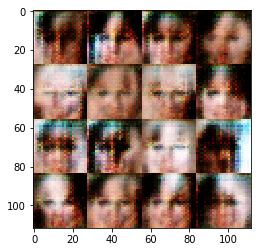

Epoch 1/1... Discriminator Loss: 1.2054... Generator Loss: 1.2210
Epoch 1/1... Discriminator Loss: 1.3142... Generator Loss: 2.1091
Epoch 1/1... Discriminator Loss: 0.8046... Generator Loss: 1.0667
Epoch 1/1... Discriminator Loss: 0.8436... Generator Loss: 1.8914
Epoch 1/1... Discriminator Loss: 1.4927... Generator Loss: 2.9544
Epoch 1/1... Discriminator Loss: 1.0529... Generator Loss: 1.2210
Epoch 1/1... Discriminator Loss: 1.0018... Generator Loss: 0.8001
Epoch 1/1... Discriminator Loss: 1.6848... Generator Loss: 0.5706
Epoch 1/1... Discriminator Loss: 2.2145... Generator Loss: 0.4735
Epoch 1/1... Discriminator Loss: 1.3109... Generator Loss: 0.6449


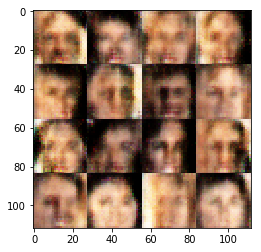

Epoch 1/1... Discriminator Loss: 1.3748... Generator Loss: 1.1278
Epoch 1/1... Discriminator Loss: 0.9142... Generator Loss: 1.1439
Epoch 1/1... Discriminator Loss: 1.8859... Generator Loss: 0.7429
Epoch 1/1... Discriminator Loss: 1.5286... Generator Loss: 1.2947
Epoch 1/1... Discriminator Loss: 1.6512... Generator Loss: 0.3829
Epoch 1/1... Discriminator Loss: 1.7026... Generator Loss: 0.5203
Epoch 1/1... Discriminator Loss: 1.5357... Generator Loss: 0.7620
Epoch 1/1... Discriminator Loss: 1.4065... Generator Loss: 1.2812
Epoch 1/1... Discriminator Loss: 1.1193... Generator Loss: 0.8631
Epoch 1/1... Discriminator Loss: 1.4623... Generator Loss: 1.2353


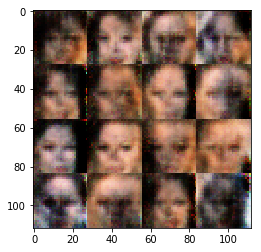

Epoch 1/1... Discriminator Loss: 1.0438... Generator Loss: 1.3598
Epoch 1/1... Discriminator Loss: 1.1113... Generator Loss: 1.0332
Epoch 1/1... Discriminator Loss: 1.8624... Generator Loss: 0.5761
Epoch 1/1... Discriminator Loss: 1.0869... Generator Loss: 0.9864
Epoch 1/1... Discriminator Loss: 1.0670... Generator Loss: 1.5018
Epoch 1/1... Discriminator Loss: 0.9386... Generator Loss: 1.1833
Epoch 1/1... Discriminator Loss: 1.1758... Generator Loss: 1.7751
Epoch 1/1... Discriminator Loss: 0.6918... Generator Loss: 1.4720
Epoch 1/1... Discriminator Loss: 1.2147... Generator Loss: 1.2441
Epoch 1/1... Discriminator Loss: 0.9842... Generator Loss: 1.7639


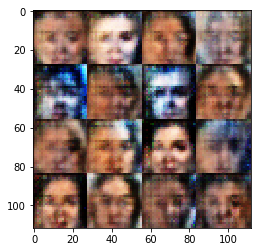

Epoch 1/1... Discriminator Loss: 1.3477... Generator Loss: 1.9364
Epoch 1/1... Discriminator Loss: 1.1694... Generator Loss: 1.4554
Epoch 1/1... Discriminator Loss: 1.8266... Generator Loss: 0.6014
Epoch 1/1... Discriminator Loss: 1.8146... Generator Loss: 0.5208
Epoch 1/1... Discriminator Loss: 0.8548... Generator Loss: 1.7642
Epoch 1/1... Discriminator Loss: 1.0051... Generator Loss: 1.4079
Epoch 1/1... Discriminator Loss: 1.5761... Generator Loss: 1.2608
Epoch 1/1... Discriminator Loss: 0.9315... Generator Loss: 1.6519
Epoch 1/1... Discriminator Loss: 1.4604... Generator Loss: 0.9087
Epoch 1/1... Discriminator Loss: 1.0366... Generator Loss: 1.3328


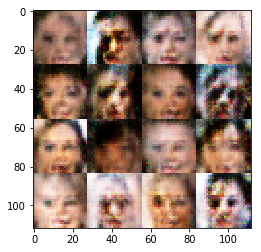

Epoch 1/1... Discriminator Loss: 0.9017... Generator Loss: 1.5292
Epoch 1/1... Discriminator Loss: 1.1954... Generator Loss: 1.5168
Epoch 1/1... Discriminator Loss: 1.6777... Generator Loss: 1.0373
Epoch 1/1... Discriminator Loss: 1.1792... Generator Loss: 0.9900
Epoch 1/1... Discriminator Loss: 1.3698... Generator Loss: 0.8195
Epoch 1/1... Discriminator Loss: 1.3126... Generator Loss: 0.8779
Epoch 1/1... Discriminator Loss: 1.1397... Generator Loss: 1.4601
Epoch 1/1... Discriminator Loss: 1.6831... Generator Loss: 1.1115
Epoch 1/1... Discriminator Loss: 1.5745... Generator Loss: 0.5693
Epoch 1/1... Discriminator Loss: 1.1327... Generator Loss: 0.9123


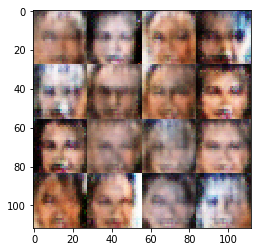

Epoch 1/1... Discriminator Loss: 0.9757... Generator Loss: 1.3305
Epoch 1/1... Discriminator Loss: 1.3111... Generator Loss: 1.1036
Epoch 1/1... Discriminator Loss: 0.9617... Generator Loss: 1.4335
Epoch 1/1... Discriminator Loss: 1.1169... Generator Loss: 0.9528
Epoch 1/1... Discriminator Loss: 1.1918... Generator Loss: 1.2655
Epoch 1/1... Discriminator Loss: 1.7694... Generator Loss: 0.7159
Epoch 1/1... Discriminator Loss: 1.1462... Generator Loss: 1.0527
Epoch 1/1... Discriminator Loss: 1.5085... Generator Loss: 0.9697
Epoch 1/1... Discriminator Loss: 1.7550... Generator Loss: 0.6582
Epoch 1/1... Discriminator Loss: 1.2359... Generator Loss: 0.9096


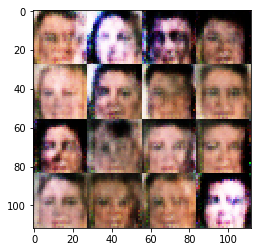

Epoch 1/1... Discriminator Loss: 1.2841... Generator Loss: 1.4048
Epoch 1/1... Discriminator Loss: 1.3765... Generator Loss: 0.9686
Epoch 1/1... Discriminator Loss: 1.6384... Generator Loss: 0.7392
Epoch 1/1... Discriminator Loss: 1.1054... Generator Loss: 1.0396
Epoch 1/1... Discriminator Loss: 1.2796... Generator Loss: 1.1570
Epoch 1/1... Discriminator Loss: 1.2891... Generator Loss: 2.1508
Epoch 1/1... Discriminator Loss: 1.4128... Generator Loss: 1.3356
Epoch 1/1... Discriminator Loss: 1.1605... Generator Loss: 1.0800
Epoch 1/1... Discriminator Loss: 1.5100... Generator Loss: 1.1624
Epoch 1/1... Discriminator Loss: 1.1530... Generator Loss: 1.1604


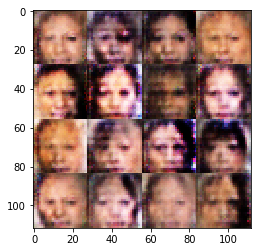

Epoch 1/1... Discriminator Loss: 0.9159... Generator Loss: 1.3003
Epoch 1/1... Discriminator Loss: 1.0048... Generator Loss: 1.1358
Epoch 1/1... Discriminator Loss: 1.3395... Generator Loss: 1.2946
Epoch 1/1... Discriminator Loss: 0.9316... Generator Loss: 1.5374
Epoch 1/1... Discriminator Loss: 1.6227... Generator Loss: 1.0320
Epoch 1/1... Discriminator Loss: 1.2808... Generator Loss: 1.2629
Epoch 1/1... Discriminator Loss: 1.1812... Generator Loss: 1.0163
Epoch 1/1... Discriminator Loss: 1.4682... Generator Loss: 1.1214
Epoch 1/1... Discriminator Loss: 1.0718... Generator Loss: 1.4377
Epoch 1/1... Discriminator Loss: 1.2849... Generator Loss: 1.5452


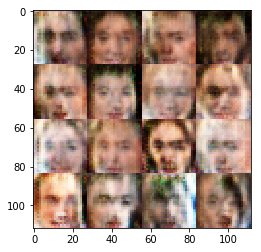

Epoch 1/1... Discriminator Loss: 1.5456... Generator Loss: 1.0791
Epoch 1/1... Discriminator Loss: 1.3770... Generator Loss: 1.4061
Epoch 1/1... Discriminator Loss: 1.7168... Generator Loss: 0.5738
Epoch 1/1... Discriminator Loss: 1.2652... Generator Loss: 0.8039
Epoch 1/1... Discriminator Loss: 1.2396... Generator Loss: 1.8295
Epoch 1/1... Discriminator Loss: 1.2018... Generator Loss: 1.2378
Epoch 1/1... Discriminator Loss: 1.1926... Generator Loss: 1.2074
Epoch 1/1... Discriminator Loss: 1.1740... Generator Loss: 0.9508
Epoch 1/1... Discriminator Loss: 1.6538... Generator Loss: 1.2132
Epoch 1/1... Discriminator Loss: 1.3490... Generator Loss: 1.4865


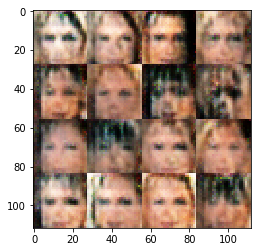

Epoch 1/1... Discriminator Loss: 1.1185... Generator Loss: 1.1660
Epoch 1/1... Discriminator Loss: 0.9937... Generator Loss: 1.3119
Epoch 1/1... Discriminator Loss: 1.2872... Generator Loss: 0.6421
Epoch 1/1... Discriminator Loss: 1.1788... Generator Loss: 1.5536
Epoch 1/1... Discriminator Loss: 1.2427... Generator Loss: 1.2038
Epoch 1/1... Discriminator Loss: 1.2335... Generator Loss: 1.0366
Epoch 1/1... Discriminator Loss: 1.3106... Generator Loss: 0.9990
Epoch 1/1... Discriminator Loss: 1.3953... Generator Loss: 1.4556
Epoch 1/1... Discriminator Loss: 1.3597... Generator Loss: 0.9972
Epoch 1/1... Discriminator Loss: 1.3053... Generator Loss: 1.0322


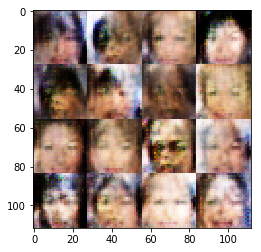

Epoch 1/1... Discriminator Loss: 1.6481... Generator Loss: 0.7423
Epoch 1/1... Discriminator Loss: 1.1724... Generator Loss: 1.0672
Epoch 1/1... Discriminator Loss: 1.5562... Generator Loss: 0.6392
Epoch 1/1... Discriminator Loss: 1.3369... Generator Loss: 0.8867
Epoch 1/1... Discriminator Loss: 1.2627... Generator Loss: 0.7720
Epoch 1/1... Discriminator Loss: 1.1072... Generator Loss: 0.9536
Epoch 1/1... Discriminator Loss: 1.2612... Generator Loss: 1.0746
Epoch 1/1... Discriminator Loss: 0.9670... Generator Loss: 1.0392
Epoch 1/1... Discriminator Loss: 1.4113... Generator Loss: 0.7643
Epoch 1/1... Discriminator Loss: 1.5222... Generator Loss: 0.9869


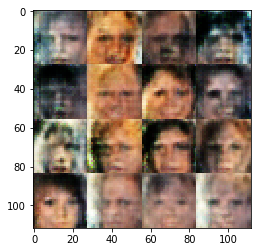

Epoch 1/1... Discriminator Loss: 1.2240... Generator Loss: 1.2160
Epoch 1/1... Discriminator Loss: 1.2371... Generator Loss: 0.8956
Epoch 1/1... Discriminator Loss: 1.3160... Generator Loss: 1.3461
Epoch 1/1... Discriminator Loss: 1.1547... Generator Loss: 1.2057
Epoch 1/1... Discriminator Loss: 1.3078... Generator Loss: 1.1759
Epoch 1/1... Discriminator Loss: 1.2304... Generator Loss: 1.0336
Epoch 1/1... Discriminator Loss: 1.1620... Generator Loss: 1.0234
Epoch 1/1... Discriminator Loss: 1.5625... Generator Loss: 1.6124
Epoch 1/1... Discriminator Loss: 1.1579... Generator Loss: 1.1087
Epoch 1/1... Discriminator Loss: 1.5986... Generator Loss: 1.3831


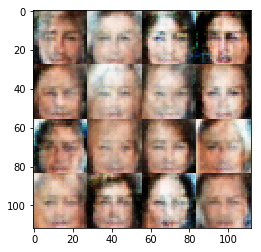

Epoch 1/1... Discriminator Loss: 1.7017... Generator Loss: 0.9123
Epoch 1/1... Discriminator Loss: 1.2684... Generator Loss: 0.8587
Epoch 1/1... Discriminator Loss: 0.9685... Generator Loss: 1.1501
Epoch 1/1... Discriminator Loss: 1.0704... Generator Loss: 1.1384
Epoch 1/1... Discriminator Loss: 1.1818... Generator Loss: 1.0082
Epoch 1/1... Discriminator Loss: 1.3715... Generator Loss: 0.9116
Epoch 1/1... Discriminator Loss: 1.7107... Generator Loss: 0.5970
Epoch 1/1... Discriminator Loss: 1.1125... Generator Loss: 0.9229
Epoch 1/1... Discriminator Loss: 1.4271... Generator Loss: 0.9238
Epoch 1/1... Discriminator Loss: 1.5531... Generator Loss: 0.8184


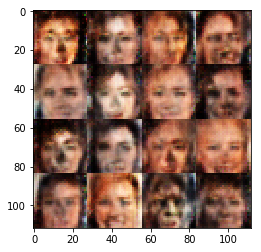

Epoch 1/1... Discriminator Loss: 1.3922... Generator Loss: 0.9816
Epoch 1/1... Discriminator Loss: 1.2428... Generator Loss: 1.0617
Epoch 1/1... Discriminator Loss: 1.5790... Generator Loss: 0.6337
Epoch 1/1... Discriminator Loss: 1.0536... Generator Loss: 1.2237
Epoch 1/1... Discriminator Loss: 1.5139... Generator Loss: 0.9122
Epoch 1/1... Discriminator Loss: 1.5151... Generator Loss: 0.6182
Epoch 1/1... Discriminator Loss: 1.3999... Generator Loss: 1.0386
Epoch 1/1... Discriminator Loss: 1.5142... Generator Loss: 0.7095
Epoch 1/1... Discriminator Loss: 1.3632... Generator Loss: 1.1450
Epoch 1/1... Discriminator Loss: 1.4884... Generator Loss: 1.7725


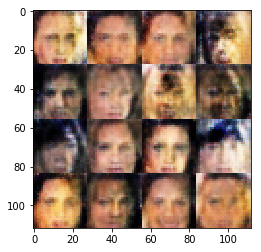

Epoch 1/1... Discriminator Loss: 1.3640... Generator Loss: 0.8767
Epoch 1/1... Discriminator Loss: 1.5010... Generator Loss: 0.8367
Epoch 1/1... Discriminator Loss: 1.2143... Generator Loss: 1.3570
Epoch 1/1... Discriminator Loss: 1.1325... Generator Loss: 1.1612
Epoch 1/1... Discriminator Loss: 1.0381... Generator Loss: 0.9239
Epoch 1/1... Discriminator Loss: 1.3284... Generator Loss: 1.2738
Epoch 1/1... Discriminator Loss: 1.4301... Generator Loss: 1.1352
Epoch 1/1... Discriminator Loss: 1.6985... Generator Loss: 0.6978
Epoch 1/1... Discriminator Loss: 1.2704... Generator Loss: 1.0344
Epoch 1/1... Discriminator Loss: 1.3641... Generator Loss: 1.2407


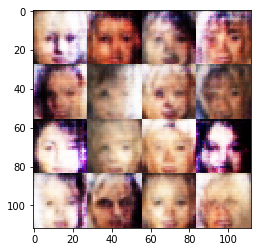

Epoch 1/1... Discriminator Loss: 1.1438... Generator Loss: 1.1100
Epoch 1/1... Discriminator Loss: 1.5533... Generator Loss: 1.1037
Epoch 1/1... Discriminator Loss: 1.3051... Generator Loss: 0.7672
Epoch 1/1... Discriminator Loss: 1.1816... Generator Loss: 1.1878
Epoch 1/1... Discriminator Loss: 1.3840... Generator Loss: 1.4256
Epoch 1/1... Discriminator Loss: 1.5748... Generator Loss: 0.6115
Epoch 1/1... Discriminator Loss: 1.1241... Generator Loss: 1.2767
Epoch 1/1... Discriminator Loss: 1.3656... Generator Loss: 0.7473
Epoch 1/1... Discriminator Loss: 1.3287... Generator Loss: 0.9389
Epoch 1/1... Discriminator Loss: 1.5433... Generator Loss: 0.7525


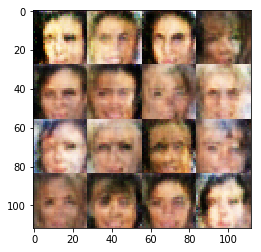

Epoch 1/1... Discriminator Loss: 1.0185... Generator Loss: 0.9779
Epoch 1/1... Discriminator Loss: 1.1220... Generator Loss: 0.9729
Epoch 1/1... Discriminator Loss: 1.1864... Generator Loss: 1.2286
Epoch 1/1... Discriminator Loss: 1.0849... Generator Loss: 1.2050
Epoch 1/1... Discriminator Loss: 1.2569... Generator Loss: 1.3503
Epoch 1/1... Discriminator Loss: 1.3762... Generator Loss: 1.0061
Epoch 1/1... Discriminator Loss: 1.3188... Generator Loss: 0.9870
Epoch 1/1... Discriminator Loss: 1.2368... Generator Loss: 1.3692
Epoch 1/1... Discriminator Loss: 1.7125... Generator Loss: 0.7141
Epoch 1/1... Discriminator Loss: 1.0382... Generator Loss: 1.6544


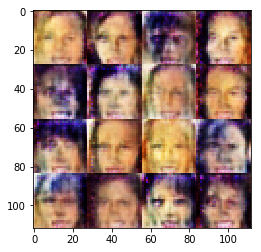

Epoch 1/1... Discriminator Loss: 1.4863... Generator Loss: 1.3483
Epoch 1/1... Discriminator Loss: 1.6172... Generator Loss: 0.6742
Epoch 1/1... Discriminator Loss: 1.4598... Generator Loss: 0.9254
Epoch 1/1... Discriminator Loss: 1.2489... Generator Loss: 0.8848
Epoch 1/1... Discriminator Loss: 1.2059... Generator Loss: 0.7978
Epoch 1/1... Discriminator Loss: 1.3868... Generator Loss: 1.0711
Epoch 1/1... Discriminator Loss: 1.2743... Generator Loss: 1.2810
Epoch 1/1... Discriminator Loss: 1.2117... Generator Loss: 0.7371
Epoch 1/1... Discriminator Loss: 1.6145... Generator Loss: 0.8707
Epoch 1/1... Discriminator Loss: 1.4696... Generator Loss: 1.2591


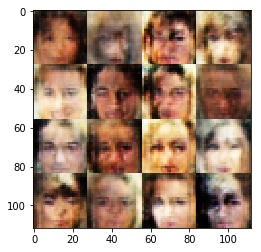

Epoch 1/1... Discriminator Loss: 1.3634... Generator Loss: 0.9761
Epoch 1/1... Discriminator Loss: 1.6384... Generator Loss: 0.6665
Epoch 1/1... Discriminator Loss: 1.7248... Generator Loss: 0.7032
Epoch 1/1... Discriminator Loss: 1.2313... Generator Loss: 0.9311
Epoch 1/1... Discriminator Loss: 1.4466... Generator Loss: 0.7503
Epoch 1/1... Discriminator Loss: 1.3275... Generator Loss: 1.4902
Epoch 1/1... Discriminator Loss: 1.1199... Generator Loss: 1.1101
Epoch 1/1... Discriminator Loss: 1.8825... Generator Loss: 0.4430
Epoch 1/1... Discriminator Loss: 1.2536... Generator Loss: 0.8292
Epoch 1/1... Discriminator Loss: 1.3077... Generator Loss: 0.7047


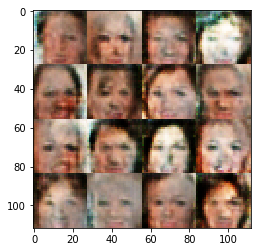

Epoch 1/1... Discriminator Loss: 1.3967... Generator Loss: 0.8226
Epoch 1/1... Discriminator Loss: 1.2125... Generator Loss: 0.9083
Epoch 1/1... Discriminator Loss: 1.3946... Generator Loss: 0.6212
Epoch 1/1... Discriminator Loss: 1.3811... Generator Loss: 0.9527
Epoch 1/1... Discriminator Loss: 1.3243... Generator Loss: 1.2421
Epoch 1/1... Discriminator Loss: 1.1931... Generator Loss: 1.0912
Epoch 1/1... Discriminator Loss: 1.4801... Generator Loss: 0.7222
Epoch 1/1... Discriminator Loss: 1.0668... Generator Loss: 1.2693
Epoch 1/1... Discriminator Loss: 0.8852... Generator Loss: 1.0718
Epoch 1/1... Discriminator Loss: 1.8904... Generator Loss: 1.0838


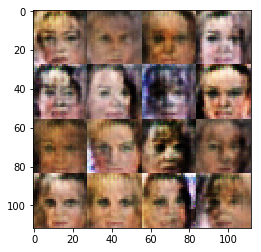

Epoch 1/1... Discriminator Loss: 1.5077... Generator Loss: 0.9260
Epoch 1/1... Discriminator Loss: 1.5675... Generator Loss: 1.1412
Epoch 1/1... Discriminator Loss: 1.3253... Generator Loss: 1.1854
Epoch 1/1... Discriminator Loss: 1.2735... Generator Loss: 1.1856
Epoch 1/1... Discriminator Loss: 1.2252... Generator Loss: 1.2822
Epoch 1/1... Discriminator Loss: 1.3731... Generator Loss: 0.9851
Epoch 1/1... Discriminator Loss: 1.2910... Generator Loss: 1.4416
Epoch 1/1... Discriminator Loss: 1.4044... Generator Loss: 0.8295
Epoch 1/1... Discriminator Loss: 1.1083... Generator Loss: 1.0769
Epoch 1/1... Discriminator Loss: 1.4436... Generator Loss: 0.7722


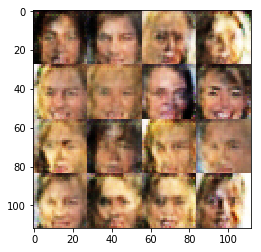

Epoch 1/1... Discriminator Loss: 1.3813... Generator Loss: 0.9449
Epoch 1/1... Discriminator Loss: 1.3167... Generator Loss: 0.5804
Epoch 1/1... Discriminator Loss: 1.8471... Generator Loss: 0.8560
Epoch 1/1... Discriminator Loss: 1.2035... Generator Loss: 0.7038
Epoch 1/1... Discriminator Loss: 1.4849... Generator Loss: 1.0449
Epoch 1/1... Discriminator Loss: 1.4629... Generator Loss: 1.3924
Epoch 1/1... Discriminator Loss: 1.1711... Generator Loss: 1.2524
Epoch 1/1... Discriminator Loss: 1.6040... Generator Loss: 1.0523
Epoch 1/1... Discriminator Loss: 1.2791... Generator Loss: 0.8934
Epoch 1/1... Discriminator Loss: 1.3030... Generator Loss: 1.1619


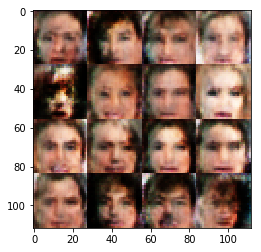

Epoch 1/1... Discriminator Loss: 1.3486... Generator Loss: 1.0919
Epoch 1/1... Discriminator Loss: 1.1680... Generator Loss: 0.7289
Epoch 1/1... Discriminator Loss: 1.1115... Generator Loss: 0.9608
Epoch 1/1... Discriminator Loss: 1.7407... Generator Loss: 0.6149
Epoch 1/1... Discriminator Loss: 1.3038... Generator Loss: 0.7724
Epoch 1/1... Discriminator Loss: 1.4647... Generator Loss: 0.7095
Epoch 1/1... Discriminator Loss: 1.5300... Generator Loss: 0.5104
Epoch 1/1... Discriminator Loss: 1.4419... Generator Loss: 0.7717
Epoch 1/1... Discriminator Loss: 1.1464... Generator Loss: 1.2557
Epoch 1/1... Discriminator Loss: 1.3424... Generator Loss: 0.7363


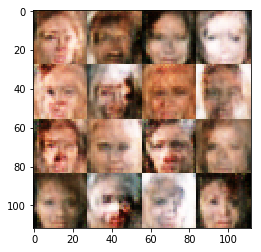

Epoch 1/1... Discriminator Loss: 1.3175... Generator Loss: 0.7707
Epoch 1/1... Discriminator Loss: 1.3971... Generator Loss: 0.8974
Epoch 1/1... Discriminator Loss: 1.1569... Generator Loss: 0.8915
Epoch 1/1... Discriminator Loss: 1.0317... Generator Loss: 1.2104
Epoch 1/1... Discriminator Loss: 1.5212... Generator Loss: 0.9586
Epoch 1/1... Discriminator Loss: 1.0842... Generator Loss: 0.9953
Epoch 1/1... Discriminator Loss: 1.4903... Generator Loss: 0.6778
Epoch 1/1... Discriminator Loss: 1.3378... Generator Loss: 1.4557
Epoch 1/1... Discriminator Loss: 1.2786... Generator Loss: 0.8592
Epoch 1/1... Discriminator Loss: 1.4580... Generator Loss: 1.3118


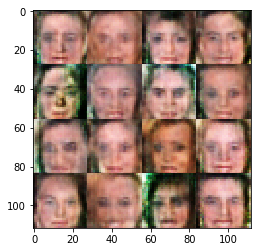

Epoch 1/1... Discriminator Loss: 1.4611... Generator Loss: 1.0430
Epoch 1/1... Discriminator Loss: 1.2025... Generator Loss: 0.8816
Epoch 1/1... Discriminator Loss: 1.4275... Generator Loss: 0.8804
Epoch 1/1... Discriminator Loss: 1.6344... Generator Loss: 0.7850
Epoch 1/1... Discriminator Loss: 1.4108... Generator Loss: 0.9569
Epoch 1/1... Discriminator Loss: 1.2744... Generator Loss: 1.2893
Epoch 1/1... Discriminator Loss: 1.5164... Generator Loss: 1.4141
Epoch 1/1... Discriminator Loss: 1.2650... Generator Loss: 1.1493
Epoch 1/1... Discriminator Loss: 1.1812... Generator Loss: 0.6797
Epoch 1/1... Discriminator Loss: 1.5167... Generator Loss: 0.7694


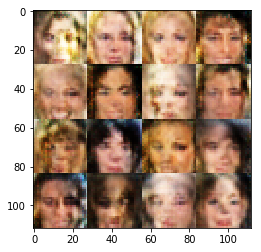

Epoch 1/1... Discriminator Loss: 1.1990... Generator Loss: 0.8754
Epoch 1/1... Discriminator Loss: 1.1187... Generator Loss: 0.9967
Epoch 1/1... Discriminator Loss: 1.4708... Generator Loss: 1.1228
Epoch 1/1... Discriminator Loss: 1.1731... Generator Loss: 0.9687
Epoch 1/1... Discriminator Loss: 1.2060... Generator Loss: 0.8659
Epoch 1/1... Discriminator Loss: 1.2234... Generator Loss: 0.8672
Epoch 1/1... Discriminator Loss: 1.3418... Generator Loss: 0.6777
Epoch 1/1... Discriminator Loss: 1.4446... Generator Loss: 1.2510
Epoch 1/1... Discriminator Loss: 1.2185... Generator Loss: 1.1329
Epoch 1/1... Discriminator Loss: 1.6382... Generator Loss: 0.8417


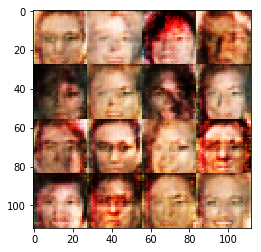

Epoch 1/1... Discriminator Loss: 1.2716... Generator Loss: 0.5963
Epoch 1/1... Discriminator Loss: 1.0041... Generator Loss: 0.8938
Epoch 1/1... Discriminator Loss: 1.2819... Generator Loss: 1.1615
Epoch 1/1... Discriminator Loss: 1.4049... Generator Loss: 0.8653
Epoch 1/1... Discriminator Loss: 1.4515... Generator Loss: 0.8649
Epoch 1/1... Discriminator Loss: 1.3474... Generator Loss: 0.7159
Epoch 1/1... Discriminator Loss: 1.1436... Generator Loss: 1.1688
Epoch 1/1... Discriminator Loss: 1.4313... Generator Loss: 0.5776
Epoch 1/1... Discriminator Loss: 1.4491... Generator Loss: 1.1409
Epoch 1/1... Discriminator Loss: 1.5776... Generator Loss: 0.8435


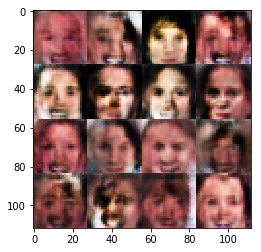

Epoch 1/1... Discriminator Loss: 0.9252... Generator Loss: 1.0747
Epoch 1/1... Discriminator Loss: 1.7390... Generator Loss: 1.3148
Epoch 1/1... Discriminator Loss: 1.7647... Generator Loss: 0.7974
Epoch 1/1... Discriminator Loss: 1.2653... Generator Loss: 0.7409
Epoch 1/1... Discriminator Loss: 0.9585... Generator Loss: 1.1456
Epoch 1/1... Discriminator Loss: 1.7310... Generator Loss: 1.3482
Epoch 1/1... Discriminator Loss: 1.2929... Generator Loss: 0.8748
Epoch 1/1... Discriminator Loss: 1.2945... Generator Loss: 1.1590
Epoch 1/1... Discriminator Loss: 1.6309... Generator Loss: 0.9968
Epoch 1/1... Discriminator Loss: 1.1565... Generator Loss: 1.1549


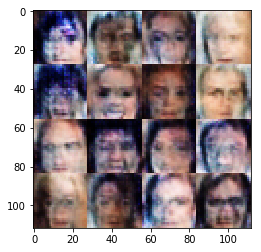

Epoch 1/1... Discriminator Loss: 1.2257... Generator Loss: 1.0290
Epoch 1/1... Discriminator Loss: 1.7529... Generator Loss: 0.9130
Epoch 1/1... Discriminator Loss: 1.3511... Generator Loss: 1.9916
Epoch 1/1... Discriminator Loss: 1.3837... Generator Loss: 0.6206
Epoch 1/1... Discriminator Loss: 1.3796... Generator Loss: 0.9495
Epoch 1/1... Discriminator Loss: 1.4178... Generator Loss: 1.2277
Epoch 1/1... Discriminator Loss: 1.0821... Generator Loss: 1.2831
Epoch 1/1... Discriminator Loss: 1.1997... Generator Loss: 0.8454
Epoch 1/1... Discriminator Loss: 1.5106... Generator Loss: 0.9819
Epoch 1/1... Discriminator Loss: 1.4609... Generator Loss: 0.7797


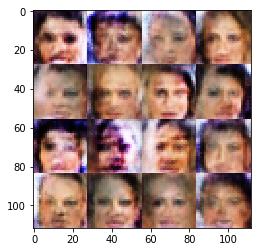

Epoch 1/1... Discriminator Loss: 1.2813... Generator Loss: 1.0208
Epoch 1/1... Discriminator Loss: 1.3674... Generator Loss: 0.6911
Epoch 1/1... Discriminator Loss: 1.2930... Generator Loss: 0.8918
Epoch 1/1... Discriminator Loss: 1.5001... Generator Loss: 1.1308
Epoch 1/1... Discriminator Loss: 1.3139... Generator Loss: 0.8823
Epoch 1/1... Discriminator Loss: 1.2250... Generator Loss: 0.6438
Epoch 1/1... Discriminator Loss: 1.2421... Generator Loss: 0.7125
Epoch 1/1... Discriminator Loss: 1.3157... Generator Loss: 1.1559
Epoch 1/1... Discriminator Loss: 1.4183... Generator Loss: 0.9327
Epoch 1/1... Discriminator Loss: 1.4588... Generator Loss: 0.6466


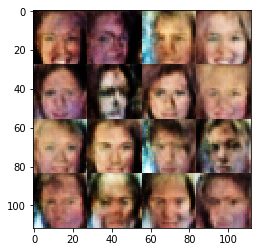

Epoch 1/1... Discriminator Loss: 1.3975... Generator Loss: 1.0922
Epoch 1/1... Discriminator Loss: 1.4500... Generator Loss: 0.9573
Epoch 1/1... Discriminator Loss: 1.0510... Generator Loss: 1.0737
Epoch 1/1... Discriminator Loss: 0.9511... Generator Loss: 1.1406
Epoch 1/1... Discriminator Loss: 1.1421... Generator Loss: 0.9123
Epoch 1/1... Discriminator Loss: 1.1115... Generator Loss: 1.3501
Epoch 1/1... Discriminator Loss: 1.7711... Generator Loss: 0.8858
Epoch 1/1... Discriminator Loss: 1.2821... Generator Loss: 0.9938
Epoch 1/1... Discriminator Loss: 1.1877... Generator Loss: 1.1254
Epoch 1/1... Discriminator Loss: 1.0880... Generator Loss: 1.4273


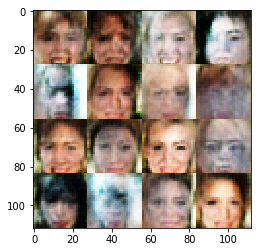

Epoch 1/1... Discriminator Loss: 1.4218... Generator Loss: 1.1324
Epoch 1/1... Discriminator Loss: 1.4264... Generator Loss: 0.8731
Epoch 1/1... Discriminator Loss: 1.0190... Generator Loss: 0.9032
Epoch 1/1... Discriminator Loss: 1.4715... Generator Loss: 0.6060
Epoch 1/1... Discriminator Loss: 1.2159... Generator Loss: 0.9707
Epoch 1/1... Discriminator Loss: 1.3293... Generator Loss: 1.0319
Epoch 1/1... Discriminator Loss: 1.3064... Generator Loss: 0.9077
Epoch 1/1... Discriminator Loss: 1.0998... Generator Loss: 0.8995
Epoch 1/1... Discriminator Loss: 1.5503... Generator Loss: 1.3270
Epoch 1/1... Discriminator Loss: 1.2655... Generator Loss: 1.1860


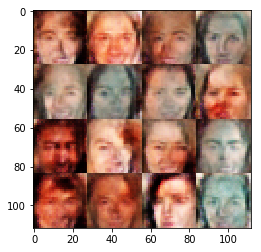

Epoch 1/1... Discriminator Loss: 1.4730... Generator Loss: 0.8220
Epoch 1/1... Discriminator Loss: 1.6581... Generator Loss: 0.8216
Epoch 1/1... Discriminator Loss: 1.1512... Generator Loss: 0.7446
Epoch 1/1... Discriminator Loss: 1.2000... Generator Loss: 1.1271
Epoch 1/1... Discriminator Loss: 1.2611... Generator Loss: 0.9043
Epoch 1/1... Discriminator Loss: 1.1834... Generator Loss: 1.0879
Epoch 1/1... Discriminator Loss: 1.4577... Generator Loss: 1.0347
Epoch 1/1... Discriminator Loss: 1.0575... Generator Loss: 1.1545
Epoch 1/1... Discriminator Loss: 1.3543... Generator Loss: 1.0925
Epoch 1/1... Discriminator Loss: 1.3093... Generator Loss: 1.0230


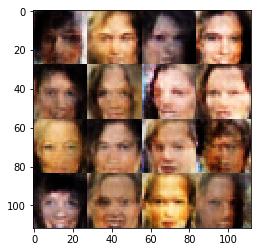

Epoch 1/1... Discriminator Loss: 1.4769... Generator Loss: 1.1254
Epoch 1/1... Discriminator Loss: 1.2955... Generator Loss: 0.9335
Epoch 1/1... Discriminator Loss: 1.5617... Generator Loss: 0.5759
Epoch 1/1... Discriminator Loss: 1.4235... Generator Loss: 0.7737
Epoch 1/1... Discriminator Loss: 0.9739... Generator Loss: 1.1689
Epoch 1/1... Discriminator Loss: 1.6708... Generator Loss: 0.9674
Epoch 1/1... Discriminator Loss: 1.3928... Generator Loss: 0.9236
Epoch 1/1... Discriminator Loss: 1.3648... Generator Loss: 0.9210
Epoch 1/1... Discriminator Loss: 1.4740... Generator Loss: 1.0414
Epoch 1/1... Discriminator Loss: 1.4459... Generator Loss: 1.0607


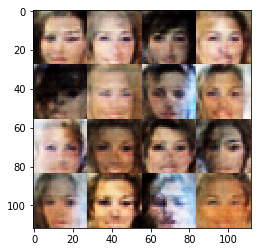

Epoch 1/1... Discriminator Loss: 1.2062... Generator Loss: 0.9550
Epoch 1/1... Discriminator Loss: 1.5125... Generator Loss: 0.9590
Epoch 1/1... Discriminator Loss: 1.7437... Generator Loss: 0.8631
Epoch 1/1... Discriminator Loss: 1.8354... Generator Loss: 0.7486
Epoch 1/1... Discriminator Loss: 1.4975... Generator Loss: 1.1650
Epoch 1/1... Discriminator Loss: 1.3710... Generator Loss: 0.8976
Epoch 1/1... Discriminator Loss: 1.4470... Generator Loss: 0.7388
Epoch 1/1... Discriminator Loss: 1.5344... Generator Loss: 0.9787
Epoch 1/1... Discriminator Loss: 1.0936... Generator Loss: 1.0329
Epoch 1/1... Discriminator Loss: 1.4205... Generator Loss: 0.7178


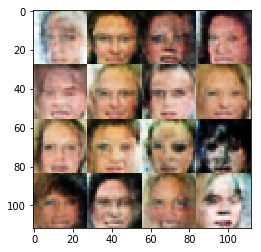

Epoch 1/1... Discriminator Loss: 1.4370... Generator Loss: 0.7788
Epoch 1/1... Discriminator Loss: 1.4371... Generator Loss: 0.8028
Epoch 1/1... Discriminator Loss: 1.3674... Generator Loss: 0.7432
Epoch 1/1... Discriminator Loss: 1.3042... Generator Loss: 0.8385
Epoch 1/1... Discriminator Loss: 1.4005... Generator Loss: 1.6111
Epoch 1/1... Discriminator Loss: 1.2677... Generator Loss: 0.8881
Epoch 1/1... Discriminator Loss: 1.3808... Generator Loss: 0.7723
Epoch 1/1... Discriminator Loss: 1.3203... Generator Loss: 1.1943
Epoch 1/1... Discriminator Loss: 1.5290... Generator Loss: 0.9164
Epoch 1/1... Discriminator Loss: 1.4747... Generator Loss: 0.7772


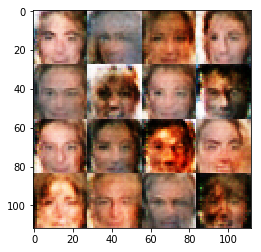

Epoch 1/1... Discriminator Loss: 1.4598... Generator Loss: 0.8306
Epoch 1/1... Discriminator Loss: 1.1151... Generator Loss: 0.7581
Epoch 1/1... Discriminator Loss: 1.5234... Generator Loss: 1.2019
Epoch 1/1... Discriminator Loss: 1.3279... Generator Loss: 0.8712
Epoch 1/1... Discriminator Loss: 1.2988... Generator Loss: 0.9940
Epoch 1/1... Discriminator Loss: 1.3772... Generator Loss: 0.9458
Epoch 1/1... Discriminator Loss: 1.3918... Generator Loss: 1.2487
Epoch 1/1... Discriminator Loss: 1.3362... Generator Loss: 1.0429
Epoch 1/1... Discriminator Loss: 1.1389... Generator Loss: 1.2410
Epoch 1/1... Discriminator Loss: 1.2875... Generator Loss: 0.8588


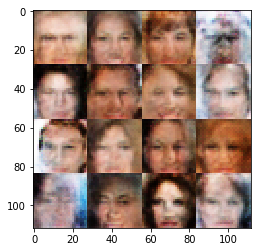

Epoch 1/1... Discriminator Loss: 1.4277... Generator Loss: 0.6457
Epoch 1/1... Discriminator Loss: 1.2038... Generator Loss: 0.8923
Epoch 1/1... Discriminator Loss: 1.0253... Generator Loss: 0.7551
Epoch 1/1... Discriminator Loss: 1.5179... Generator Loss: 0.7542
Epoch 1/1... Discriminator Loss: 1.1531... Generator Loss: 0.8346
Epoch 1/1... Discriminator Loss: 1.3285... Generator Loss: 0.8116
Epoch 1/1... Discriminator Loss: 1.3288... Generator Loss: 1.2270
Epoch 1/1... Discriminator Loss: 1.3470... Generator Loss: 0.8733
Epoch 1/1... Discriminator Loss: 1.1105... Generator Loss: 0.9724
Epoch 1/1... Discriminator Loss: 1.2418... Generator Loss: 0.9544


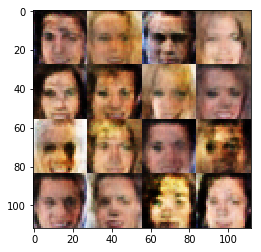

Epoch 1/1... Discriminator Loss: 1.4317... Generator Loss: 0.6289
Epoch 1/1... Discriminator Loss: 1.4967... Generator Loss: 0.8414
Epoch 1/1... Discriminator Loss: 1.4477... Generator Loss: 0.8366
Epoch 1/1... Discriminator Loss: 1.3121... Generator Loss: 0.7623
Epoch 1/1... Discriminator Loss: 1.3301... Generator Loss: 0.7965
Epoch 1/1... Discriminator Loss: 1.3256... Generator Loss: 0.8590
Epoch 1/1... Discriminator Loss: 1.0252... Generator Loss: 0.9569
Epoch 1/1... Discriminator Loss: 1.4245... Generator Loss: 0.9336
Epoch 1/1... Discriminator Loss: 1.2267... Generator Loss: 0.7376
Epoch 1/1... Discriminator Loss: 1.6229... Generator Loss: 0.7031


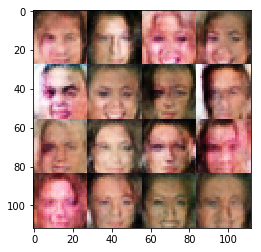

Epoch 1/1... Discriminator Loss: 1.3460... Generator Loss: 0.7587
Epoch 1/1... Discriminator Loss: 1.4985... Generator Loss: 0.9692
Epoch 1/1... Discriminator Loss: 1.3062... Generator Loss: 1.3221
Epoch 1/1... Discriminator Loss: 1.2914... Generator Loss: 0.6098
Epoch 1/1... Discriminator Loss: 1.2378... Generator Loss: 0.9610
Epoch 1/1... Discriminator Loss: 1.3529... Generator Loss: 0.7953
Epoch 1/1... Discriminator Loss: 1.3870... Generator Loss: 0.8222
Epoch 1/1... Discriminator Loss: 1.3433... Generator Loss: 1.0640
Epoch 1/1... Discriminator Loss: 1.5097... Generator Loss: 0.7711
Epoch 1/1... Discriminator Loss: 0.9470... Generator Loss: 1.1662


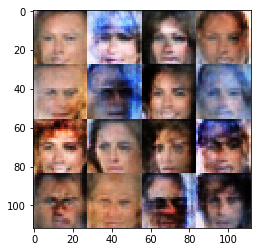

Epoch 1/1... Discriminator Loss: 1.3895... Generator Loss: 0.8797
Epoch 1/1... Discriminator Loss: 1.5525... Generator Loss: 0.9246
Epoch 1/1... Discriminator Loss: 1.3498... Generator Loss: 0.8546
Epoch 1/1... Discriminator Loss: 1.5070... Generator Loss: 1.3647
Epoch 1/1... Discriminator Loss: 1.4988... Generator Loss: 1.1729
Epoch 1/1... Discriminator Loss: 1.3097... Generator Loss: 0.9696
Epoch 1/1... Discriminator Loss: 1.1965... Generator Loss: 1.1597
Epoch 1/1... Discriminator Loss: 1.2651... Generator Loss: 1.0245
Epoch 1/1... Discriminator Loss: 1.2820... Generator Loss: 0.6490
Epoch 1/1... Discriminator Loss: 1.4412... Generator Loss: 0.9622


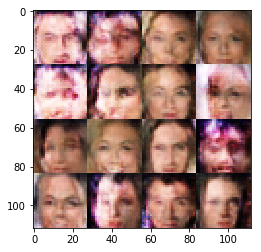

Epoch 1/1... Discriminator Loss: 1.5040... Generator Loss: 1.0292
Epoch 1/1... Discriminator Loss: 1.2409... Generator Loss: 0.8431
Epoch 1/1... Discriminator Loss: 1.3231... Generator Loss: 1.2484
Epoch 1/1... Discriminator Loss: 1.5891... Generator Loss: 0.6224
Epoch 1/1... Discriminator Loss: 1.3597... Generator Loss: 0.6816
Epoch 1/1... Discriminator Loss: 1.3937... Generator Loss: 0.9210
Epoch 1/1... Discriminator Loss: 1.2822... Generator Loss: 0.8874
Epoch 1/1... Discriminator Loss: 1.6019... Generator Loss: 0.6698
Epoch 1/1... Discriminator Loss: 1.3873... Generator Loss: 0.7804
Epoch 1/1... Discriminator Loss: 1.3603... Generator Loss: 0.8715


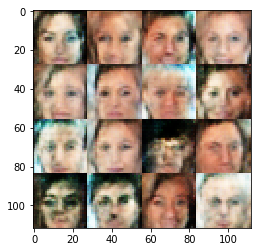

Epoch 1/1... Discriminator Loss: 1.4334... Generator Loss: 0.9372
Epoch 1/1... Discriminator Loss: 1.2215... Generator Loss: 0.8096
Epoch 1/1... Discriminator Loss: 1.2768... Generator Loss: 0.9712
Epoch 1/1... Discriminator Loss: 1.2091... Generator Loss: 0.9446
Epoch 1/1... Discriminator Loss: 1.4653... Generator Loss: 0.9595
Epoch 1/1... Discriminator Loss: 1.1636... Generator Loss: 1.2007
Epoch 1/1... Discriminator Loss: 1.4033... Generator Loss: 1.0547
Epoch 1/1... Discriminator Loss: 1.4022... Generator Loss: 0.8856
Epoch 1/1... Discriminator Loss: 1.6246... Generator Loss: 0.6723
Epoch 1/1... Discriminator Loss: 1.5152... Generator Loss: 0.7065


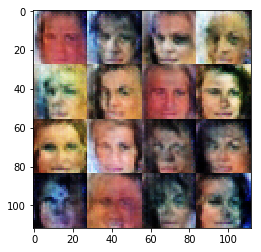

Epoch 1/1... Discriminator Loss: 1.5371... Generator Loss: 0.4934
Epoch 1/1... Discriminator Loss: 1.1830... Generator Loss: 1.3233
Epoch 1/1... Discriminator Loss: 1.2528... Generator Loss: 0.8887
Epoch 1/1... Discriminator Loss: 1.3121... Generator Loss: 1.1326
Epoch 1/1... Discriminator Loss: 1.3259... Generator Loss: 0.9538
Epoch 1/1... Discriminator Loss: 1.3949... Generator Loss: 0.7010
Epoch 1/1... Discriminator Loss: 1.2724... Generator Loss: 1.2953
Epoch 1/1... Discriminator Loss: 1.2962... Generator Loss: 0.7861
Epoch 1/1... Discriminator Loss: 1.0539... Generator Loss: 0.8759
Epoch 1/1... Discriminator Loss: 1.5316... Generator Loss: 0.9692


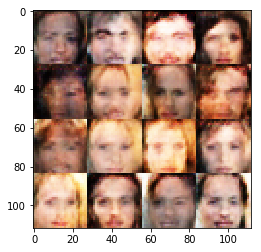

Epoch 1/1... Discriminator Loss: 1.3908... Generator Loss: 0.7107
Epoch 1/1... Discriminator Loss: 1.2376... Generator Loss: 0.9333
Epoch 1/1... Discriminator Loss: 1.5583... Generator Loss: 0.7643
Epoch 1/1... Discriminator Loss: 1.3220... Generator Loss: 1.0869
Epoch 1/1... Discriminator Loss: 1.2472... Generator Loss: 0.8597
Epoch 1/1... Discriminator Loss: 1.1600... Generator Loss: 1.0162
Epoch 1/1... Discriminator Loss: 1.3829... Generator Loss: 0.7357
Epoch 1/1... Discriminator Loss: 1.3936... Generator Loss: 1.0577
Epoch 1/1... Discriminator Loss: 1.3626... Generator Loss: 0.7960
Epoch 1/1... Discriminator Loss: 1.2714... Generator Loss: 0.7858


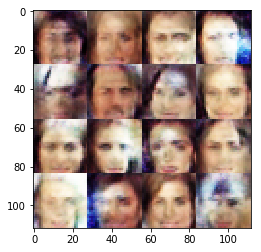

Epoch 1/1... Discriminator Loss: 1.3254... Generator Loss: 1.0400
Epoch 1/1... Discriminator Loss: 1.3123... Generator Loss: 0.7153
Epoch 1/1... Discriminator Loss: 1.2713... Generator Loss: 0.9412
Epoch 1/1... Discriminator Loss: 1.4183... Generator Loss: 1.0883
Epoch 1/1... Discriminator Loss: 1.2662... Generator Loss: 0.9091
Epoch 1/1... Discriminator Loss: 1.4266... Generator Loss: 0.9486
Epoch 1/1... Discriminator Loss: 1.3708... Generator Loss: 0.6792
Epoch 1/1... Discriminator Loss: 1.3619... Generator Loss: 1.3065
Epoch 1/1... Discriminator Loss: 1.2013... Generator Loss: 1.0853
Epoch 1/1... Discriminator Loss: 1.1661... Generator Loss: 1.0100


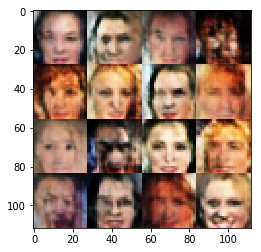

Epoch 1/1... Discriminator Loss: 1.3185... Generator Loss: 1.0346
Epoch 1/1... Discriminator Loss: 1.2527... Generator Loss: 1.4355
Epoch 1/1... Discriminator Loss: 1.2925... Generator Loss: 0.5964
Epoch 1/1... Discriminator Loss: 1.3683... Generator Loss: 0.8529
Epoch 1/1... Discriminator Loss: 1.1648... Generator Loss: 0.8415
Epoch 1/1... Discriminator Loss: 1.1316... Generator Loss: 0.9116
Epoch 1/1... Discriminator Loss: 1.3235... Generator Loss: 0.7908
Epoch 1/1... Discriminator Loss: 1.2451... Generator Loss: 0.8058
Epoch 1/1... Discriminator Loss: 1.2912... Generator Loss: 0.7830
Epoch 1/1... Discriminator Loss: 1.2817... Generator Loss: 0.9605


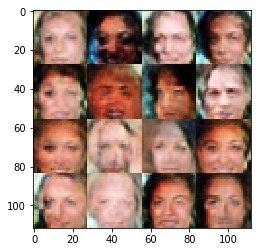

Epoch 1/1... Discriminator Loss: 1.2432... Generator Loss: 0.5997
Epoch 1/1... Discriminator Loss: 1.7248... Generator Loss: 0.4674
Epoch 1/1... Discriminator Loss: 1.3675... Generator Loss: 0.7721
Epoch 1/1... Discriminator Loss: 1.2012... Generator Loss: 0.9034
Epoch 1/1... Discriminator Loss: 1.3032... Generator Loss: 1.2588
Epoch 1/1... Discriminator Loss: 1.1674... Generator Loss: 0.9166
Epoch 1/1... Discriminator Loss: 1.3722... Generator Loss: 0.6761
Epoch 1/1... Discriminator Loss: 1.4103... Generator Loss: 1.0639
Epoch 1/1... Discriminator Loss: 1.2025... Generator Loss: 1.0081
Epoch 1/1... Discriminator Loss: 1.1554... Generator Loss: 0.9141


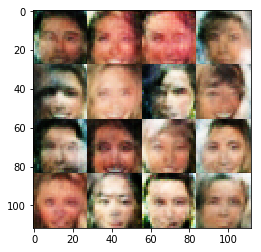

Epoch 1/1... Discriminator Loss: 1.4046... Generator Loss: 0.6071
Epoch 1/1... Discriminator Loss: 1.4090... Generator Loss: 1.8089
Epoch 1/1... Discriminator Loss: 1.5157... Generator Loss: 1.1693
Epoch 1/1... Discriminator Loss: 1.1675... Generator Loss: 0.9930
Epoch 1/1... Discriminator Loss: 1.2649... Generator Loss: 1.1132
Epoch 1/1... Discriminator Loss: 1.3768... Generator Loss: 0.9228
Epoch 1/1... Discriminator Loss: 1.1470... Generator Loss: 0.8988
Epoch 1/1... Discriminator Loss: 1.2034... Generator Loss: 0.9676
Epoch 1/1... Discriminator Loss: 1.2222... Generator Loss: 0.6938
Epoch 1/1... Discriminator Loss: 1.6508... Generator Loss: 0.5879


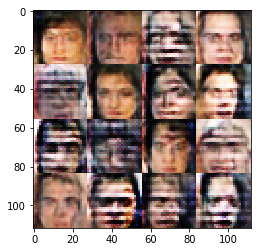

Epoch 1/1... Discriminator Loss: 1.2862... Generator Loss: 0.8407
Epoch 1/1... Discriminator Loss: 1.5119... Generator Loss: 0.9408
Epoch 1/1... Discriminator Loss: 1.3985... Generator Loss: 0.6745
Epoch 1/1... Discriminator Loss: 1.5274... Generator Loss: 0.6448
Epoch 1/1... Discriminator Loss: 1.2177... Generator Loss: 0.7546
Epoch 1/1... Discriminator Loss: 1.1997... Generator Loss: 0.9125
Epoch 1/1... Discriminator Loss: 1.3032... Generator Loss: 1.0999
Epoch 1/1... Discriminator Loss: 1.4390... Generator Loss: 0.9373
Epoch 1/1... Discriminator Loss: 1.4174... Generator Loss: 0.9120
Epoch 1/1... Discriminator Loss: 1.2976... Generator Loss: 1.1452


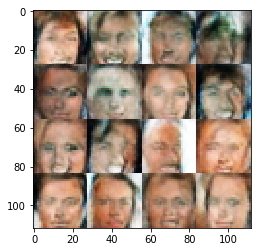

Epoch 1/1... Discriminator Loss: 1.3093... Generator Loss: 1.1549
Epoch 1/1... Discriminator Loss: 1.4129... Generator Loss: 1.0677
Epoch 1/1... Discriminator Loss: 1.1410... Generator Loss: 1.2753
Epoch 1/1... Discriminator Loss: 1.5390... Generator Loss: 1.0315
Epoch 1/1... Discriminator Loss: 1.2725... Generator Loss: 0.8630
Epoch 1/1... Discriminator Loss: 1.3251... Generator Loss: 1.0216
Epoch 1/1... Discriminator Loss: 1.5428... Generator Loss: 0.6509
Epoch 1/1... Discriminator Loss: 1.1980... Generator Loss: 0.7173
Epoch 1/1... Discriminator Loss: 1.2624... Generator Loss: 0.9924
Epoch 1/1... Discriminator Loss: 1.3280... Generator Loss: 0.7097


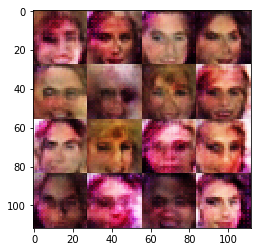

Epoch 1/1... Discriminator Loss: 1.3079... Generator Loss: 1.0137
Epoch 1/1... Discriminator Loss: 1.5982... Generator Loss: 1.0567
Epoch 1/1... Discriminator Loss: 1.2092... Generator Loss: 1.3366
Epoch 1/1... Discriminator Loss: 1.3590... Generator Loss: 0.9148
Epoch 1/1... Discriminator Loss: 1.3740... Generator Loss: 0.9903
Epoch 1/1... Discriminator Loss: 1.2316... Generator Loss: 0.6784
Epoch 1/1... Discriminator Loss: 1.2852... Generator Loss: 1.1785
Epoch 1/1... Discriminator Loss: 1.0336... Generator Loss: 0.9348
Epoch 1/1... Discriminator Loss: 1.3551... Generator Loss: 0.8919
Epoch 1/1... Discriminator Loss: 1.4167... Generator Loss: 0.6113


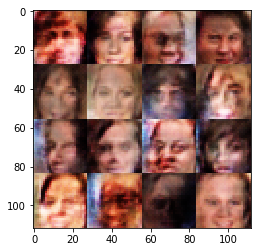

Epoch 1/1... Discriminator Loss: 1.2873... Generator Loss: 0.9997
Epoch 1/1... Discriminator Loss: 1.2549... Generator Loss: 0.8710
Epoch 1/1... Discriminator Loss: 1.4075... Generator Loss: 0.9893
Epoch 1/1... Discriminator Loss: 1.4941... Generator Loss: 0.8376
Epoch 1/1... Discriminator Loss: 1.7208... Generator Loss: 0.6774
Epoch 1/1... Discriminator Loss: 1.5076... Generator Loss: 0.7853
Epoch 1/1... Discriminator Loss: 1.3604... Generator Loss: 1.5159
Epoch 1/1... Discriminator Loss: 1.3865... Generator Loss: 0.7146
Epoch 1/1... Discriminator Loss: 1.5511... Generator Loss: 0.8960
Epoch 1/1... Discriminator Loss: 1.4296... Generator Loss: 1.0356


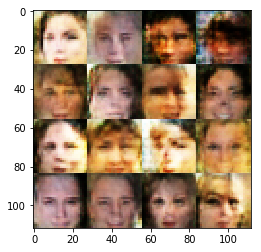

Epoch 1/1... Discriminator Loss: 1.3747... Generator Loss: 1.1093
Epoch 1/1... Discriminator Loss: 1.1294... Generator Loss: 1.2353
Epoch 1/1... Discriminator Loss: 1.3784... Generator Loss: 0.7303
Epoch 1/1... Discriminator Loss: 1.3415... Generator Loss: 0.9329
Epoch 1/1... Discriminator Loss: 1.1411... Generator Loss: 1.1974
Epoch 1/1... Discriminator Loss: 1.2749... Generator Loss: 0.8272
Epoch 1/1... Discriminator Loss: 1.3487... Generator Loss: 0.8304
Epoch 1/1... Discriminator Loss: 1.1690... Generator Loss: 0.9860
Epoch 1/1... Discriminator Loss: 1.3876... Generator Loss: 0.8067
Epoch 1/1... Discriminator Loss: 1.3524... Generator Loss: 0.5844


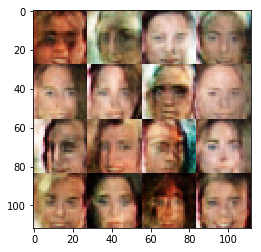

Epoch 1/1... Discriminator Loss: 1.2072... Generator Loss: 0.8760
Epoch 1/1... Discriminator Loss: 1.4901... Generator Loss: 0.8443
Epoch 1/1... Discriminator Loss: 1.0622... Generator Loss: 1.3903
Epoch 1/1... Discriminator Loss: 1.5247... Generator Loss: 0.8251
Epoch 1/1... Discriminator Loss: 1.4430... Generator Loss: 0.7914
Epoch 1/1... Discriminator Loss: 1.1228... Generator Loss: 0.8489
Epoch 1/1... Discriminator Loss: 1.3850... Generator Loss: 0.6205
Epoch 1/1... Discriminator Loss: 1.2209... Generator Loss: 0.8441
Epoch 1/1... Discriminator Loss: 1.3386... Generator Loss: 1.1695
Epoch 1/1... Discriminator Loss: 1.2565... Generator Loss: 0.6292


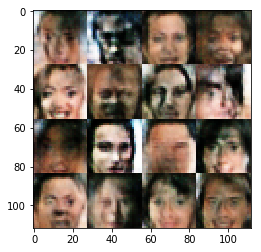

Epoch 1/1... Discriminator Loss: 1.3839... Generator Loss: 0.9530
Epoch 1/1... Discriminator Loss: 1.2194... Generator Loss: 0.8816
Epoch 1/1... Discriminator Loss: 1.1471... Generator Loss: 0.7637
Epoch 1/1... Discriminator Loss: 1.2229... Generator Loss: 1.3341
Epoch 1/1... Discriminator Loss: 1.0574... Generator Loss: 1.0535
Epoch 1/1... Discriminator Loss: 1.2145... Generator Loss: 0.9078
Epoch 1/1... Discriminator Loss: 1.2297... Generator Loss: 0.8125
Epoch 1/1... Discriminator Loss: 1.2337... Generator Loss: 0.9510
Epoch 1/1... Discriminator Loss: 1.1441... Generator Loss: 1.1448
Epoch 1/1... Discriminator Loss: 1.2975... Generator Loss: 0.8808


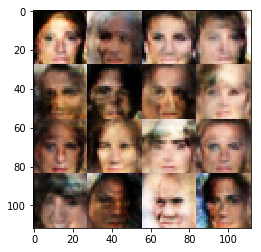

Epoch 1/1... Discriminator Loss: 1.4341... Generator Loss: 0.8973
Epoch 1/1... Discriminator Loss: 1.2992... Generator Loss: 0.9296
Epoch 1/1... Discriminator Loss: 1.2712... Generator Loss: 0.9462
Epoch 1/1... Discriminator Loss: 1.3719... Generator Loss: 0.9421
Epoch 1/1... Discriminator Loss: 1.4360... Generator Loss: 0.8869
Epoch 1/1... Discriminator Loss: 1.3476... Generator Loss: 1.0050
Epoch 1/1... Discriminator Loss: 1.5312... Generator Loss: 1.2100
Epoch 1/1... Discriminator Loss: 1.0736... Generator Loss: 0.9428
Epoch 1/1... Discriminator Loss: 1.1671... Generator Loss: 0.9560
Epoch 1/1... Discriminator Loss: 1.4913... Generator Loss: 0.7749


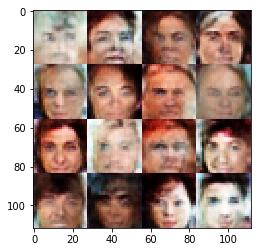

Epoch 1/1... Discriminator Loss: 1.2209... Generator Loss: 0.7596
Epoch 1/1... Discriminator Loss: 1.3689... Generator Loss: 0.9353
Epoch 1/1... Discriminator Loss: 1.1005... Generator Loss: 0.8941
Epoch 1/1... Discriminator Loss: 1.2967... Generator Loss: 0.8397
Epoch 1/1... Discriminator Loss: 1.2814... Generator Loss: 1.0021
Epoch 1/1... Discriminator Loss: 1.3199... Generator Loss: 0.8936
Epoch 1/1... Discriminator Loss: 1.2782... Generator Loss: 0.9713
Epoch 1/1... Discriminator Loss: 1.5031... Generator Loss: 1.0933
Epoch 1/1... Discriminator Loss: 1.4067... Generator Loss: 0.9063
Epoch 1/1... Discriminator Loss: 1.2885... Generator Loss: 0.7751


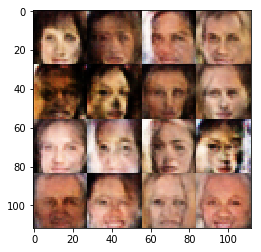

Epoch 1/1... Discriminator Loss: 1.3040... Generator Loss: 0.9427
Epoch 1/1... Discriminator Loss: 1.2164... Generator Loss: 0.9767
Epoch 1/1... Discriminator Loss: 1.1857... Generator Loss: 0.7886
Epoch 1/1... Discriminator Loss: 1.1786... Generator Loss: 1.0342
Epoch 1/1... Discriminator Loss: 1.5587... Generator Loss: 0.6978
Epoch 1/1... Discriminator Loss: 1.3683... Generator Loss: 0.7728
Epoch 1/1... Discriminator Loss: 1.4114... Generator Loss: 0.7535
Epoch 1/1... Discriminator Loss: 1.0950... Generator Loss: 0.8300
Epoch 1/1... Discriminator Loss: 1.0810... Generator Loss: 0.8742
Epoch 1/1... Discriminator Loss: 1.3277... Generator Loss: 0.8105


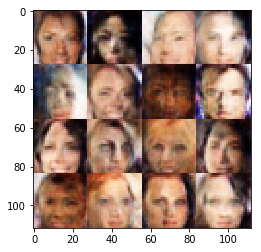

Epoch 1/1... Discriminator Loss: 1.4954... Generator Loss: 0.8513
Epoch 1/1... Discriminator Loss: 1.2721... Generator Loss: 0.8217
Epoch 1/1... Discriminator Loss: 1.3893... Generator Loss: 0.9713
Epoch 1/1... Discriminator Loss: 1.4096... Generator Loss: 0.7065
Epoch 1/1... Discriminator Loss: 1.0763... Generator Loss: 0.8574
Epoch 1/1... Discriminator Loss: 1.1353... Generator Loss: 1.0710
Epoch 1/1... Discriminator Loss: 1.2292... Generator Loss: 1.1850
Epoch 1/1... Discriminator Loss: 1.2442... Generator Loss: 0.8180
Epoch 1/1... Discriminator Loss: 1.2944... Generator Loss: 0.8723
Epoch 1/1... Discriminator Loss: 1.3198... Generator Loss: 0.8652


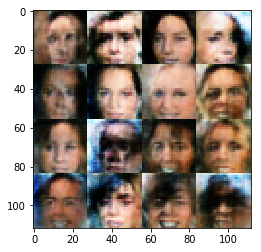

Epoch 1/1... Discriminator Loss: 1.3686... Generator Loss: 1.0553
Epoch 1/1... Discriminator Loss: 1.3037... Generator Loss: 0.9890
Epoch 1/1... Discriminator Loss: 1.2332... Generator Loss: 0.8132
Epoch 1/1... Discriminator Loss: 1.4464... Generator Loss: 1.0602
Epoch 1/1... Discriminator Loss: 1.0843... Generator Loss: 0.8854
Epoch 1/1... Discriminator Loss: 1.6001... Generator Loss: 0.8567
Epoch 1/1... Discriminator Loss: 1.2446... Generator Loss: 0.7184
Epoch 1/1... Discriminator Loss: 1.2397... Generator Loss: 0.8839
Epoch 1/1... Discriminator Loss: 1.2987... Generator Loss: 0.8329
Epoch 1/1... Discriminator Loss: 1.6547... Generator Loss: 0.7750


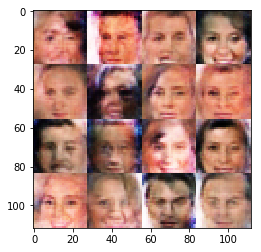

Epoch 1/1... Discriminator Loss: 1.2249... Generator Loss: 0.8105
Epoch 1/1... Discriminator Loss: 0.9542... Generator Loss: 1.0524
Epoch 1/1... Discriminator Loss: 1.0926... Generator Loss: 1.2494
Epoch 1/1... Discriminator Loss: 1.3746... Generator Loss: 0.7110
Epoch 1/1... Discriminator Loss: 1.3984... Generator Loss: 0.9739
Epoch 1/1... Discriminator Loss: 1.4214... Generator Loss: 0.8473
Epoch 1/1... Discriminator Loss: 1.4097... Generator Loss: 0.7011
Epoch 1/1... Discriminator Loss: 1.3580... Generator Loss: 0.9174
Epoch 1/1... Discriminator Loss: 1.2595... Generator Loss: 1.0349
Epoch 1/1... Discriminator Loss: 1.3782... Generator Loss: 0.9431


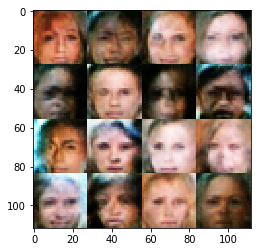

Epoch 1/1... Discriminator Loss: 1.2656... Generator Loss: 1.1539
Epoch 1/1... Discriminator Loss: 1.1658... Generator Loss: 1.1045
Epoch 1/1... Discriminator Loss: 1.4037... Generator Loss: 0.8517
Epoch 1/1... Discriminator Loss: 1.3782... Generator Loss: 0.6823
Epoch 1/1... Discriminator Loss: 1.3065... Generator Loss: 0.7746
Epoch 1/1... Discriminator Loss: 1.4436... Generator Loss: 0.9154
Epoch 1/1... Discriminator Loss: 1.4483... Generator Loss: 0.8461
Epoch 1/1... Discriminator Loss: 1.8912... Generator Loss: 0.3295
Epoch 1/1... Discriminator Loss: 1.2849... Generator Loss: 0.8667
Epoch 1/1... Discriminator Loss: 1.3837... Generator Loss: 0.7304


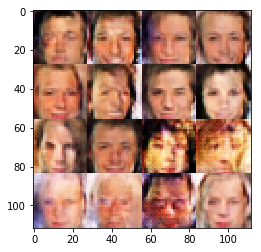

Epoch 1/1... Discriminator Loss: 1.1457... Generator Loss: 0.7271
Epoch 1/1... Discriminator Loss: 1.4694... Generator Loss: 0.8778
Epoch 1/1... Discriminator Loss: 1.3035... Generator Loss: 0.7802
Epoch 1/1... Discriminator Loss: 1.5233... Generator Loss: 0.7296
Epoch 1/1... Discriminator Loss: 1.3587... Generator Loss: 1.0045
Epoch 1/1... Discriminator Loss: 1.3095... Generator Loss: 0.6070
Epoch 1/1... Discriminator Loss: 1.4996... Generator Loss: 0.6003
Epoch 1/1... Discriminator Loss: 1.4031... Generator Loss: 0.7148
Epoch 1/1... Discriminator Loss: 1.3885... Generator Loss: 0.7262
Epoch 1/1... Discriminator Loss: 1.2909... Generator Loss: 0.7827


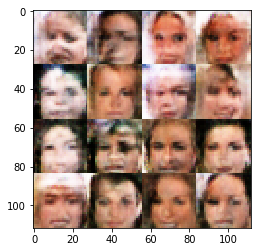

Epoch 1/1... Discriminator Loss: 1.2166... Generator Loss: 0.7303
Epoch 1/1... Discriminator Loss: 1.4141... Generator Loss: 0.7575
Epoch 1/1... Discriminator Loss: 1.2707... Generator Loss: 1.0071
Epoch 1/1... Discriminator Loss: 0.9898... Generator Loss: 0.9736
Epoch 1/1... Discriminator Loss: 1.4828... Generator Loss: 0.5811
Epoch 1/1... Discriminator Loss: 1.3011... Generator Loss: 1.2385
Epoch 1/1... Discriminator Loss: 1.3968... Generator Loss: 0.7343
Epoch 1/1... Discriminator Loss: 1.5704... Generator Loss: 0.6236
Epoch 1/1... Discriminator Loss: 1.0822... Generator Loss: 0.9256
Epoch 1/1... Discriminator Loss: 1.3558... Generator Loss: 0.9488


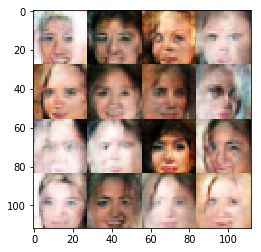

Epoch 1/1... Discriminator Loss: 1.4453... Generator Loss: 0.7447
Epoch 1/1... Discriminator Loss: 1.5340... Generator Loss: 0.8596
Epoch 1/1... Discriminator Loss: 1.4929... Generator Loss: 0.6287
Epoch 1/1... Discriminator Loss: 1.6540... Generator Loss: 0.6081
Epoch 1/1... Discriminator Loss: 1.8045... Generator Loss: 0.4877
Epoch 1/1... Discriminator Loss: 1.2593... Generator Loss: 0.9654
Epoch 1/1... Discriminator Loss: 1.4220... Generator Loss: 1.2116
Epoch 1/1... Discriminator Loss: 1.2807... Generator Loss: 0.8143
Epoch 1/1... Discriminator Loss: 1.2291... Generator Loss: 1.0699
Epoch 1/1... Discriminator Loss: 1.3988... Generator Loss: 0.9313


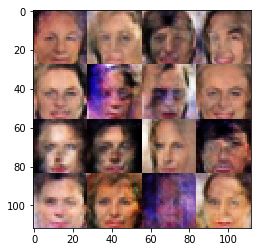

Epoch 1/1... Discriminator Loss: 1.2988... Generator Loss: 1.0461
Epoch 1/1... Discriminator Loss: 1.4549... Generator Loss: 0.8282
Epoch 1/1... Discriminator Loss: 1.4158... Generator Loss: 0.7960
Epoch 1/1... Discriminator Loss: 1.3551... Generator Loss: 0.7296
Epoch 1/1... Discriminator Loss: 1.3944... Generator Loss: 0.8519
Epoch 1/1... Discriminator Loss: 1.4903... Generator Loss: 0.8114
Epoch 1/1... Discriminator Loss: 1.4234... Generator Loss: 0.8979
Epoch 1/1... Discriminator Loss: 1.2758... Generator Loss: 0.8582
Epoch 1/1... Discriminator Loss: 1.2491... Generator Loss: 1.0180
Epoch 1/1... Discriminator Loss: 1.3122... Generator Loss: 0.8101


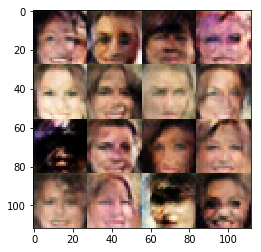

Epoch 1/1... Discriminator Loss: 1.2561... Generator Loss: 1.0182
Epoch 1/1... Discriminator Loss: 1.3366... Generator Loss: 0.7573
Epoch 1/1... Discriminator Loss: 1.3249... Generator Loss: 0.7220
Epoch 1/1... Discriminator Loss: 1.2115... Generator Loss: 0.9924
Epoch 1/1... Discriminator Loss: 1.2634... Generator Loss: 0.8026
Epoch 1/1... Discriminator Loss: 1.5141... Generator Loss: 0.6133
Epoch 1/1... Discriminator Loss: 1.0661... Generator Loss: 1.1177
Epoch 1/1... Discriminator Loss: 1.3463... Generator Loss: 0.7426
Epoch 1/1... Discriminator Loss: 1.6406... Generator Loss: 0.6229
Epoch 1/1... Discriminator Loss: 1.1724... Generator Loss: 1.0777


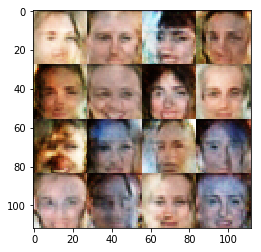

Epoch 1/1... Discriminator Loss: 1.7153... Generator Loss: 0.6012
Epoch 1/1... Discriminator Loss: 1.4490... Generator Loss: 0.9496
Epoch 1/1... Discriminator Loss: 1.3273... Generator Loss: 1.0416
Epoch 1/1... Discriminator Loss: 1.3914... Generator Loss: 1.2402
Epoch 1/1... Discriminator Loss: 1.0928... Generator Loss: 0.7814
Epoch 1/1... Discriminator Loss: 1.3845... Generator Loss: 0.6239
Epoch 1/1... Discriminator Loss: 1.3261... Generator Loss: 0.5560
Epoch 1/1... Discriminator Loss: 1.3662... Generator Loss: 0.6725
Epoch 1/1... Discriminator Loss: 1.0643... Generator Loss: 0.8847
Epoch 1/1... Discriminator Loss: 1.4931... Generator Loss: 0.6692


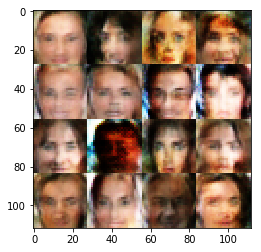

Epoch 1/1... Discriminator Loss: 1.2000... Generator Loss: 0.8526
Epoch 1/1... Discriminator Loss: 1.4469... Generator Loss: 0.7500
Epoch 1/1... Discriminator Loss: 1.2969... Generator Loss: 0.7837
Epoch 1/1... Discriminator Loss: 1.4189... Generator Loss: 0.8075
Epoch 1/1... Discriminator Loss: 1.3523... Generator Loss: 1.2737
Epoch 1/1... Discriminator Loss: 1.3840... Generator Loss: 0.8670
Epoch 1/1... Discriminator Loss: 1.3631... Generator Loss: 0.5984
Epoch 1/1... Discriminator Loss: 1.4309... Generator Loss: 1.1145
Epoch 1/1... Discriminator Loss: 1.3384... Generator Loss: 1.0086
Epoch 1/1... Discriminator Loss: 1.1729... Generator Loss: 0.6926


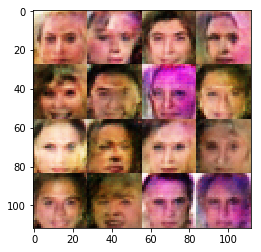

Epoch 1/1... Discriminator Loss: 1.5027... Generator Loss: 0.5485
Epoch 1/1... Discriminator Loss: 1.3673... Generator Loss: 1.6118
Epoch 1/1... Discriminator Loss: 1.2673... Generator Loss: 1.0303
Epoch 1/1... Discriminator Loss: 1.4329... Generator Loss: 0.7174
Epoch 1/1... Discriminator Loss: 1.2790... Generator Loss: 0.7288
Epoch 1/1... Discriminator Loss: 1.2029... Generator Loss: 1.1022
Epoch 1/1... Discriminator Loss: 1.4354... Generator Loss: 0.9114
Epoch 1/1... Discriminator Loss: 1.1703... Generator Loss: 1.0897
Epoch 1/1... Discriminator Loss: 1.2669... Generator Loss: 1.0361
Epoch 1/1... Discriminator Loss: 1.1435... Generator Loss: 0.8672


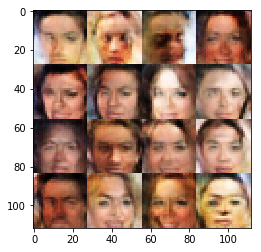

Epoch 1/1... Discriminator Loss: 1.5423... Generator Loss: 0.9053
Epoch 1/1... Discriminator Loss: 1.4319... Generator Loss: 0.8397
Epoch 1/1... Discriminator Loss: 1.2042... Generator Loss: 0.9064
Epoch 1/1... Discriminator Loss: 1.0131... Generator Loss: 0.9860
Epoch 1/1... Discriminator Loss: 1.3024... Generator Loss: 0.7280
Epoch 1/1... Discriminator Loss: 1.3807... Generator Loss: 0.5736
Epoch 1/1... Discriminator Loss: 1.4465... Generator Loss: 0.8301
Epoch 1/1... Discriminator Loss: 1.4987... Generator Loss: 0.9526
Epoch 1/1... Discriminator Loss: 1.6706... Generator Loss: 0.6899
Epoch 1/1... Discriminator Loss: 1.2702... Generator Loss: 0.9550


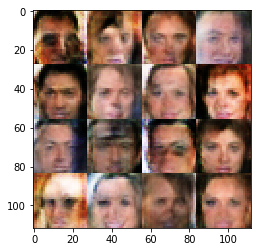

Epoch 1/1... Discriminator Loss: 1.4269... Generator Loss: 0.8655
Epoch 1/1... Discriminator Loss: 1.5330... Generator Loss: 0.8436
Epoch 1/1... Discriminator Loss: 1.2744... Generator Loss: 0.9095
Epoch 1/1... Discriminator Loss: 1.2202... Generator Loss: 0.7956
Epoch 1/1... Discriminator Loss: 1.3172... Generator Loss: 0.8606
Epoch 1/1... Discriminator Loss: 1.1604... Generator Loss: 0.7269
Epoch 1/1... Discriminator Loss: 1.1572... Generator Loss: 0.8411
Epoch 1/1... Discriminator Loss: 1.3375... Generator Loss: 1.2102
Epoch 1/1... Discriminator Loss: 1.3460... Generator Loss: 0.9874
Epoch 1/1... Discriminator Loss: 1.4101... Generator Loss: 0.8161


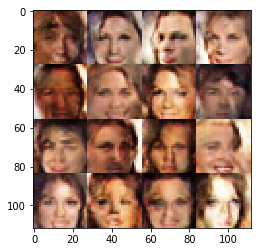

Epoch 1/1... Discriminator Loss: 1.0667... Generator Loss: 1.0250
Epoch 1/1... Discriminator Loss: 1.4333... Generator Loss: 0.6939
Epoch 1/1... Discriminator Loss: 1.2661... Generator Loss: 0.8354
Epoch 1/1... Discriminator Loss: 1.4716... Generator Loss: 0.7504
Epoch 1/1... Discriminator Loss: 1.3030... Generator Loss: 0.7471
Epoch 1/1... Discriminator Loss: 1.3464... Generator Loss: 0.7088
Epoch 1/1... Discriminator Loss: 0.9839... Generator Loss: 1.0430
Epoch 1/1... Discriminator Loss: 1.6372... Generator Loss: 1.1947
Epoch 1/1... Discriminator Loss: 1.3893... Generator Loss: 0.9717
Epoch 1/1... Discriminator Loss: 1.1091... Generator Loss: 0.7099


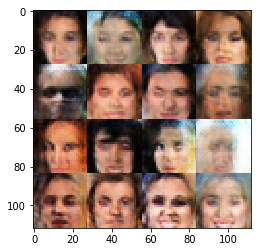

Epoch 1/1... Discriminator Loss: 1.1656... Generator Loss: 0.7044
Epoch 1/1... Discriminator Loss: 1.3861... Generator Loss: 1.1529
Epoch 1/1... Discriminator Loss: 1.1200... Generator Loss: 0.9295
Epoch 1/1... Discriminator Loss: 1.3293... Generator Loss: 1.0692
Epoch 1/1... Discriminator Loss: 1.2397... Generator Loss: 0.8838
Epoch 1/1... Discriminator Loss: 1.1306... Generator Loss: 0.7928
Epoch 1/1... Discriminator Loss: 1.6153... Generator Loss: 0.6517
Epoch 1/1... Discriminator Loss: 1.2703... Generator Loss: 0.6008
Epoch 1/1... Discriminator Loss: 1.5111... Generator Loss: 0.8199
Epoch 1/1... Discriminator Loss: 1.1827... Generator Loss: 0.9676


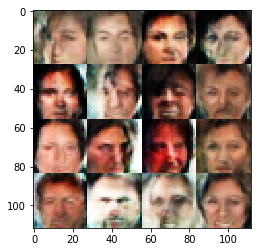

Epoch 1/1... Discriminator Loss: 1.1539... Generator Loss: 0.9349
Epoch 1/1... Discriminator Loss: 1.2756... Generator Loss: 0.7663
Epoch 1/1... Discriminator Loss: 1.0959... Generator Loss: 1.2147
Epoch 1/1... Discriminator Loss: 1.4746... Generator Loss: 0.8607
Epoch 1/1... Discriminator Loss: 1.4978... Generator Loss: 0.8188
Epoch 1/1... Discriminator Loss: 1.3888... Generator Loss: 0.8427
Epoch 1/1... Discriminator Loss: 1.2574... Generator Loss: 0.7609
Epoch 1/1... Discriminator Loss: 1.2789... Generator Loss: 1.3961
Epoch 1/1... Discriminator Loss: 1.4677... Generator Loss: 0.9488
Epoch 1/1... Discriminator Loss: 1.1038... Generator Loss: 0.8744


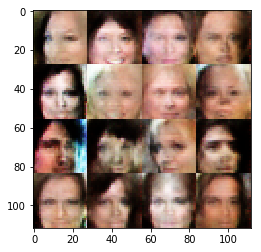

Epoch 1/1... Discriminator Loss: 1.2826... Generator Loss: 1.0106
Epoch 1/1... Discriminator Loss: 1.1934... Generator Loss: 0.8925
Epoch 1/1... Discriminator Loss: 1.3215... Generator Loss: 1.8854
Epoch 1/1... Discriminator Loss: 1.1755... Generator Loss: 0.7209
Epoch 1/1... Discriminator Loss: 1.3046... Generator Loss: 0.8281
Epoch 1/1... Discriminator Loss: 1.3634... Generator Loss: 0.8602
Epoch 1/1... Discriminator Loss: 1.4022... Generator Loss: 1.3837
Epoch 1/1... Discriminator Loss: 1.2387... Generator Loss: 0.9126
Epoch 1/1... Discriminator Loss: 1.5643... Generator Loss: 0.7009
Epoch 1/1... Discriminator Loss: 1.2223... Generator Loss: 1.0250


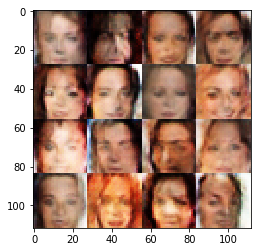

Epoch 1/1... Discriminator Loss: 1.3408... Generator Loss: 0.8828
Epoch 1/1... Discriminator Loss: 1.4131... Generator Loss: 0.7314
Epoch 1/1... Discriminator Loss: 1.5150... Generator Loss: 0.8110
Epoch 1/1... Discriminator Loss: 1.5332... Generator Loss: 0.7913
Epoch 1/1... Discriminator Loss: 1.4743... Generator Loss: 0.9069
Epoch 1/1... Discriminator Loss: 1.3112... Generator Loss: 1.1720
Epoch 1/1... Discriminator Loss: 1.3749... Generator Loss: 0.7844
Epoch 1/1... Discriminator Loss: 1.5388... Generator Loss: 0.9996
Epoch 1/1... Discriminator Loss: 1.4220... Generator Loss: 0.7044
Epoch 1/1... Discriminator Loss: 1.4491... Generator Loss: 0.7903


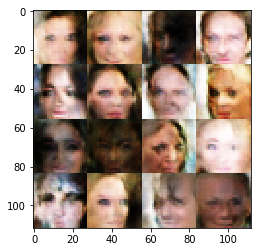

Epoch 1/1... Discriminator Loss: 1.3409... Generator Loss: 1.1928
Epoch 1/1... Discriminator Loss: 1.5751... Generator Loss: 0.7725
Epoch 1/1... Discriminator Loss: 1.3950... Generator Loss: 1.1015
Epoch 1/1... Discriminator Loss: 1.2792... Generator Loss: 0.8151
Epoch 1/1... Discriminator Loss: 1.2814... Generator Loss: 0.9069
Epoch 1/1... Discriminator Loss: 1.5083... Generator Loss: 0.6928
Epoch 1/1... Discriminator Loss: 1.4728... Generator Loss: 0.7377
Epoch 1/1... Discriminator Loss: 1.4063... Generator Loss: 1.2987
Epoch 1/1... Discriminator Loss: 1.2828... Generator Loss: 1.0460
Epoch 1/1... Discriminator Loss: 1.2181... Generator Loss: 0.9464


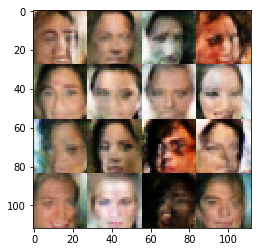

Epoch 1/1... Discriminator Loss: 1.1183... Generator Loss: 0.8524
Epoch 1/1... Discriminator Loss: 1.5503... Generator Loss: 0.7100
Epoch 1/1... Discriminator Loss: 1.5527... Generator Loss: 0.4075
Epoch 1/1... Discriminator Loss: 1.5968... Generator Loss: 0.8549
Epoch 1/1... Discriminator Loss: 1.4386... Generator Loss: 0.6803
Epoch 1/1... Discriminator Loss: 1.2013... Generator Loss: 0.9006
Epoch 1/1... Discriminator Loss: 1.4631... Generator Loss: 0.8858
Epoch 1/1... Discriminator Loss: 1.3285... Generator Loss: 0.8992
Epoch 1/1... Discriminator Loss: 1.2229... Generator Loss: 0.9825
Epoch 1/1... Discriminator Loss: 1.1351... Generator Loss: 0.9156


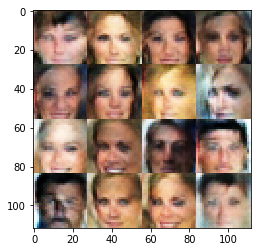

Epoch 1/1... Discriminator Loss: 1.3122... Generator Loss: 0.8497
Epoch 1/1... Discriminator Loss: 1.1321... Generator Loss: 0.8330
Epoch 1/1... Discriminator Loss: 1.4682... Generator Loss: 1.0669
Epoch 1/1... Discriminator Loss: 1.4526... Generator Loss: 0.8663
Epoch 1/1... Discriminator Loss: 1.2120... Generator Loss: 1.1854
Epoch 1/1... Discriminator Loss: 1.2345... Generator Loss: 0.7816
Epoch 1/1... Discriminator Loss: 1.2694... Generator Loss: 1.2925
Epoch 1/1... Discriminator Loss: 1.3410... Generator Loss: 1.0545
Epoch 1/1... Discriminator Loss: 1.3624... Generator Loss: 0.9442
Epoch 1/1... Discriminator Loss: 1.3346... Generator Loss: 0.5240


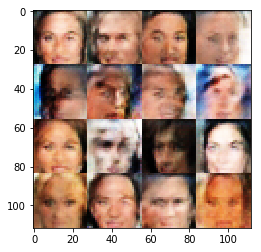

Epoch 1/1... Discriminator Loss: 1.5935... Generator Loss: 0.8613
Epoch 1/1... Discriminator Loss: 1.3144... Generator Loss: 1.0403
Epoch 1/1... Discriminator Loss: 1.4060... Generator Loss: 0.6731
Epoch 1/1... Discriminator Loss: 1.0959... Generator Loss: 1.0276
Epoch 1/1... Discriminator Loss: 1.4481... Generator Loss: 0.6438
Epoch 1/1... Discriminator Loss: 1.2903... Generator Loss: 1.1232
Epoch 1/1... Discriminator Loss: 1.2595... Generator Loss: 1.0035
Epoch 1/1... Discriminator Loss: 1.4976... Generator Loss: 0.8969
Epoch 1/1... Discriminator Loss: 1.5099... Generator Loss: 0.6185
Epoch 1/1... Discriminator Loss: 1.3820... Generator Loss: 0.9307


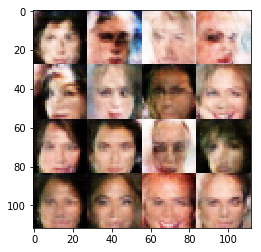

Epoch 1/1... Discriminator Loss: 1.2196... Generator Loss: 1.0485
Epoch 1/1... Discriminator Loss: 1.2613... Generator Loss: 1.0483
Epoch 1/1... Discriminator Loss: 1.5910... Generator Loss: 0.7646
Epoch 1/1... Discriminator Loss: 1.4554... Generator Loss: 0.9809
Epoch 1/1... Discriminator Loss: 1.4600... Generator Loss: 0.7104
Epoch 1/1... Discriminator Loss: 1.3544... Generator Loss: 0.7962
Epoch 1/1... Discriminator Loss: 1.9452... Generator Loss: 0.5582
Epoch 1/1... Discriminator Loss: 1.2844... Generator Loss: 0.7805
Epoch 1/1... Discriminator Loss: 1.3934... Generator Loss: 1.0712
Epoch 1/1... Discriminator Loss: 1.3496... Generator Loss: 0.9068


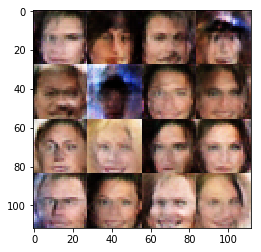

Epoch 1/1... Discriminator Loss: 1.3344... Generator Loss: 0.7750
Epoch 1/1... Discriminator Loss: 1.2108... Generator Loss: 0.9000
Epoch 1/1... Discriminator Loss: 1.3785... Generator Loss: 0.7854
Epoch 1/1... Discriminator Loss: 1.3218... Generator Loss: 0.8218
Epoch 1/1... Discriminator Loss: 1.3003... Generator Loss: 1.0138
Epoch 1/1... Discriminator Loss: 1.2836... Generator Loss: 0.9194
Epoch 1/1... Discriminator Loss: 1.4568... Generator Loss: 0.7700
Epoch 1/1... Discriminator Loss: 1.4894... Generator Loss: 0.7185
Epoch 1/1... Discriminator Loss: 1.1370... Generator Loss: 0.9916
Epoch 1/1... Discriminator Loss: 1.2064... Generator Loss: 1.1090


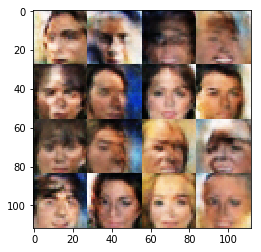

Epoch 1/1... Discriminator Loss: 1.2294... Generator Loss: 0.7178
Epoch 1/1... Discriminator Loss: 1.0953... Generator Loss: 1.0509
Epoch 1/1... Discriminator Loss: 1.2937... Generator Loss: 0.6578
Epoch 1/1... Discriminator Loss: 1.1933... Generator Loss: 1.0173
Epoch 1/1... Discriminator Loss: 1.2429... Generator Loss: 0.9654
Epoch 1/1... Discriminator Loss: 1.2691... Generator Loss: 1.1508
Epoch 1/1... Discriminator Loss: 1.0393... Generator Loss: 0.8910
Epoch 1/1... Discriminator Loss: 1.3097... Generator Loss: 0.7742
Epoch 1/1... Discriminator Loss: 1.4823... Generator Loss: 0.8136
Epoch 1/1... Discriminator Loss: 1.2304... Generator Loss: 0.9189


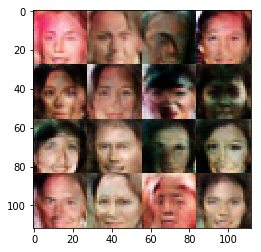

Epoch 1/1... Discriminator Loss: 1.3161... Generator Loss: 1.0085
Epoch 1/1... Discriminator Loss: 1.4453... Generator Loss: 0.8423
Epoch 1/1... Discriminator Loss: 1.5043... Generator Loss: 1.0432
Epoch 1/1... Discriminator Loss: 1.3515... Generator Loss: 0.8643
Epoch 1/1... Discriminator Loss: 1.4042... Generator Loss: 0.6816
Epoch 1/1... Discriminator Loss: 1.1822... Generator Loss: 0.9108
Epoch 1/1... Discriminator Loss: 1.4706... Generator Loss: 0.7552
Epoch 1/1... Discriminator Loss: 1.2794... Generator Loss: 1.0139
Epoch 1/1... Discriminator Loss: 1.4514... Generator Loss: 0.6353
Epoch 1/1... Discriminator Loss: 1.2235... Generator Loss: 0.7733


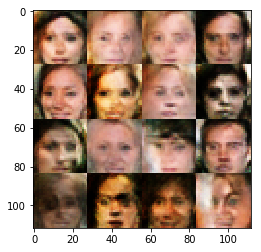

Epoch 1/1... Discriminator Loss: 1.4842... Generator Loss: 0.8710
Epoch 1/1... Discriminator Loss: 1.2394... Generator Loss: 0.9245
Epoch 1/1... Discriminator Loss: 1.3488... Generator Loss: 0.8223
Epoch 1/1... Discriminator Loss: 1.3720... Generator Loss: 0.8968
Epoch 1/1... Discriminator Loss: 1.4058... Generator Loss: 0.9676
Epoch 1/1... Discriminator Loss: 1.2540... Generator Loss: 0.7853
Epoch 1/1... Discriminator Loss: 1.2806... Generator Loss: 0.9868
Epoch 1/1... Discriminator Loss: 1.2069... Generator Loss: 1.0190
Epoch 1/1... Discriminator Loss: 1.2739... Generator Loss: 0.7261
Epoch 1/1... Discriminator Loss: 1.2781... Generator Loss: 1.1595


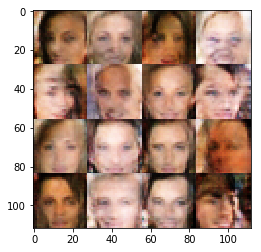

Epoch 1/1... Discriminator Loss: 1.5132... Generator Loss: 0.8480
Epoch 1/1... Discriminator Loss: 1.1171... Generator Loss: 1.0735
Epoch 1/1... Discriminator Loss: 1.2096... Generator Loss: 1.0142
Epoch 1/1... Discriminator Loss: 1.4371... Generator Loss: 0.8346
Epoch 1/1... Discriminator Loss: 1.3334... Generator Loss: 1.0265
Epoch 1/1... Discriminator Loss: 1.2606... Generator Loss: 0.9725
Epoch 1/1... Discriminator Loss: 1.2883... Generator Loss: 1.2208
Epoch 1/1... Discriminator Loss: 1.4422... Generator Loss: 0.5909
Epoch 1/1... Discriminator Loss: 1.8290... Generator Loss: 0.6008
Epoch 1/1... Discriminator Loss: 1.2744... Generator Loss: 0.7477


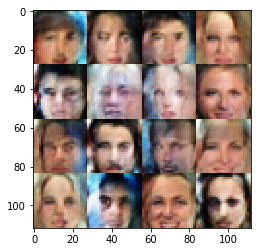

Epoch 1/1... Discriminator Loss: 1.2111... Generator Loss: 0.9853
Epoch 1/1... Discriminator Loss: 0.9872... Generator Loss: 1.1060
Epoch 1/1... Discriminator Loss: 1.2734... Generator Loss: 0.9466
Epoch 1/1... Discriminator Loss: 1.5167... Generator Loss: 1.1271
Epoch 1/1... Discriminator Loss: 1.3402... Generator Loss: 1.0933
Epoch 1/1... Discriminator Loss: 1.3370... Generator Loss: 0.9901
Epoch 1/1... Discriminator Loss: 1.3744... Generator Loss: 0.9161
Epoch 1/1... Discriminator Loss: 1.1064... Generator Loss: 0.7375
Epoch 1/1... Discriminator Loss: 1.2627... Generator Loss: 1.3414
Epoch 1/1... Discriminator Loss: 1.5000... Generator Loss: 1.1343


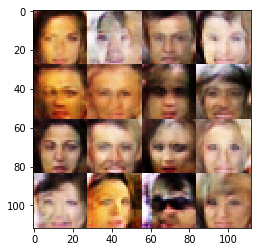

Epoch 1/1... Discriminator Loss: 1.3254... Generator Loss: 0.8176
Epoch 1/1... Discriminator Loss: 1.4537... Generator Loss: 0.9405
Epoch 1/1... Discriminator Loss: 1.4117... Generator Loss: 0.6676
Epoch 1/1... Discriminator Loss: 1.1994... Generator Loss: 0.9234
Epoch 1/1... Discriminator Loss: 1.4670... Generator Loss: 0.4845
Epoch 1/1... Discriminator Loss: 1.3848... Generator Loss: 0.9187
Epoch 1/1... Discriminator Loss: 1.2423... Generator Loss: 0.7816
Epoch 1/1... Discriminator Loss: 1.3331... Generator Loss: 0.7655
Epoch 1/1... Discriminator Loss: 1.2485... Generator Loss: 1.1730
Epoch 1/1... Discriminator Loss: 1.2617... Generator Loss: 0.9617


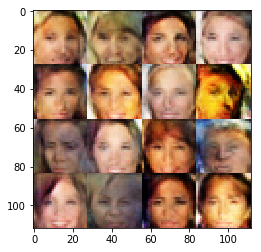

Epoch 1/1... Discriminator Loss: 1.1899... Generator Loss: 0.9996
Epoch 1/1... Discriminator Loss: 1.6429... Generator Loss: 0.8994
Epoch 1/1... Discriminator Loss: 1.4740... Generator Loss: 0.5982
Epoch 1/1... Discriminator Loss: 1.4822... Generator Loss: 0.5769
Epoch 1/1... Discriminator Loss: 1.2554... Generator Loss: 0.9886
Epoch 1/1... Discriminator Loss: 1.2480... Generator Loss: 1.0946
Epoch 1/1... Discriminator Loss: 1.4808... Generator Loss: 0.7422
Epoch 1/1... Discriminator Loss: 1.4039... Generator Loss: 0.6274
Epoch 1/1... Discriminator Loss: 1.4651... Generator Loss: 1.0130
Epoch 1/1... Discriminator Loss: 1.3565... Generator Loss: 0.6776


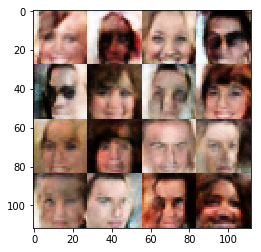

Epoch 1/1... Discriminator Loss: 1.6152... Generator Loss: 0.8133
Epoch 1/1... Discriminator Loss: 1.1638... Generator Loss: 0.8134
Epoch 1/1... Discriminator Loss: 1.1449... Generator Loss: 1.1610
Epoch 1/1... Discriminator Loss: 1.2983... Generator Loss: 1.2087
Epoch 1/1... Discriminator Loss: 1.2637... Generator Loss: 1.1671
Epoch 1/1... Discriminator Loss: 1.1489... Generator Loss: 0.8033
Epoch 1/1... Discriminator Loss: 1.1256... Generator Loss: 0.7206
Epoch 1/1... Discriminator Loss: 1.7720... Generator Loss: 0.7655
Epoch 1/1... Discriminator Loss: 1.4572... Generator Loss: 0.7342
Epoch 1/1... Discriminator Loss: 1.3368... Generator Loss: 1.0623


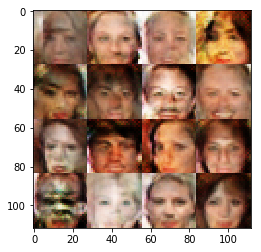

Epoch 1/1... Discriminator Loss: 1.5195... Generator Loss: 0.7221
Epoch 1/1... Discriminator Loss: 1.3363... Generator Loss: 0.9282
Epoch 1/1... Discriminator Loss: 1.3709... Generator Loss: 0.9167
Epoch 1/1... Discriminator Loss: 1.0950... Generator Loss: 0.9062
Epoch 1/1... Discriminator Loss: 1.4016... Generator Loss: 0.9383
Epoch 1/1... Discriminator Loss: 1.3388... Generator Loss: 1.3155
Epoch 1/1... Discriminator Loss: 1.5809... Generator Loss: 0.7081
Epoch 1/1... Discriminator Loss: 1.2646... Generator Loss: 0.8206
Epoch 1/1... Discriminator Loss: 1.3102... Generator Loss: 0.7589
Epoch 1/1... Discriminator Loss: 1.1634... Generator Loss: 0.7351


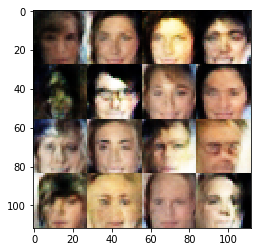

Epoch 1/1... Discriminator Loss: 1.4700... Generator Loss: 0.7909
Epoch 1/1... Discriminator Loss: 1.1558... Generator Loss: 0.8768
Epoch 1/1... Discriminator Loss: 1.5290... Generator Loss: 0.9734
Epoch 1/1... Discriminator Loss: 1.3979... Generator Loss: 0.8657
Epoch 1/1... Discriminator Loss: 1.2709... Generator Loss: 0.8532
Epoch 1/1... Discriminator Loss: 1.2581... Generator Loss: 0.7560
Epoch 1/1... Discriminator Loss: 1.2486... Generator Loss: 0.7984
Epoch 1/1... Discriminator Loss: 1.4929... Generator Loss: 0.8107
Epoch 1/1... Discriminator Loss: 1.2545... Generator Loss: 1.1575
Epoch 1/1... Discriminator Loss: 1.2790... Generator Loss: 1.0481


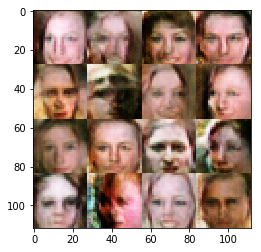

Epoch 1/1... Discriminator Loss: 1.4366... Generator Loss: 0.8683
Epoch 1/1... Discriminator Loss: 1.4250... Generator Loss: 1.1266
Epoch 1/1... Discriminator Loss: 1.3538... Generator Loss: 0.8391
Epoch 1/1... Discriminator Loss: 1.2051... Generator Loss: 0.9899
Epoch 1/1... Discriminator Loss: 1.3932... Generator Loss: 0.5987
Epoch 1/1... Discriminator Loss: 1.2300... Generator Loss: 1.0351
Epoch 1/1... Discriminator Loss: 1.4558... Generator Loss: 1.1335
Epoch 1/1... Discriminator Loss: 1.2445... Generator Loss: 0.8115
Epoch 1/1... Discriminator Loss: 1.3237... Generator Loss: 1.2863
Epoch 1/1... Discriminator Loss: 1.0448... Generator Loss: 0.9929


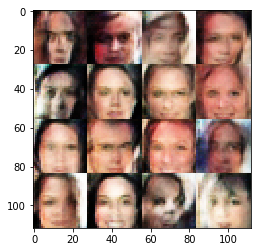

Epoch 1/1... Discriminator Loss: 1.2367... Generator Loss: 0.9776
Epoch 1/1... Discriminator Loss: 1.3581... Generator Loss: 0.9944
Epoch 1/1... Discriminator Loss: 1.2217... Generator Loss: 0.9094
Epoch 1/1... Discriminator Loss: 1.3369... Generator Loss: 0.7726
Epoch 1/1... Discriminator Loss: 1.1749... Generator Loss: 1.0466
Epoch 1/1... Discriminator Loss: 1.2042... Generator Loss: 1.0260
Epoch 1/1... Discriminator Loss: 1.0923... Generator Loss: 0.9417
Epoch 1/1... Discriminator Loss: 1.3233... Generator Loss: 0.9338
Epoch 1/1... Discriminator Loss: 1.5037... Generator Loss: 0.7525
Epoch 1/1... Discriminator Loss: 1.3844... Generator Loss: 0.8554


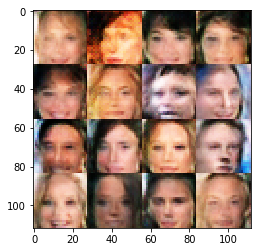

Epoch 1/1... Discriminator Loss: 1.3553... Generator Loss: 1.1463
Epoch 1/1... Discriminator Loss: 1.4110... Generator Loss: 0.8678
Epoch 1/1... Discriminator Loss: 1.3943... Generator Loss: 1.0144
Epoch 1/1... Discriminator Loss: 1.2299... Generator Loss: 0.9717
Epoch 1/1... Discriminator Loss: 1.2201... Generator Loss: 0.7943
Epoch 1/1... Discriminator Loss: 1.5328... Generator Loss: 0.7761
Epoch 1/1... Discriminator Loss: 1.3431... Generator Loss: 0.7554
Epoch 1/1... Discriminator Loss: 1.3580... Generator Loss: 0.8975
Epoch 1/1... Discriminator Loss: 1.1348... Generator Loss: 0.8901
Epoch 1/1... Discriminator Loss: 1.4811... Generator Loss: 0.6597


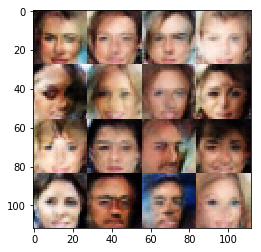

Epoch 1/1... Discriminator Loss: 1.4635... Generator Loss: 0.9479
Epoch 1/1... Discriminator Loss: 1.3252... Generator Loss: 1.1077
Epoch 1/1... Discriminator Loss: 1.4016... Generator Loss: 0.7812
Epoch 1/1... Discriminator Loss: 1.2414... Generator Loss: 0.9668
Epoch 1/1... Discriminator Loss: 1.3226... Generator Loss: 0.6045
Epoch 1/1... Discriminator Loss: 1.2439... Generator Loss: 0.8516
Epoch 1/1... Discriminator Loss: 1.0619... Generator Loss: 1.0785
Epoch 1/1... Discriminator Loss: 1.2925... Generator Loss: 0.7564
Epoch 1/1... Discriminator Loss: 1.0747... Generator Loss: 0.7549
Epoch 1/1... Discriminator Loss: 1.5180... Generator Loss: 0.8309


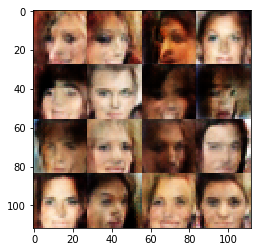

Epoch 1/1... Discriminator Loss: 1.3705... Generator Loss: 1.0984
Epoch 1/1... Discriminator Loss: 1.1467... Generator Loss: 0.8882
Epoch 1/1... Discriminator Loss: 1.3721... Generator Loss: 0.6501
Epoch 1/1... Discriminator Loss: 1.1777... Generator Loss: 0.8875
Epoch 1/1... Discriminator Loss: 1.3188... Generator Loss: 0.7536
Epoch 1/1... Discriminator Loss: 1.2967... Generator Loss: 0.9542
Epoch 1/1... Discriminator Loss: 1.5133... Generator Loss: 0.8003
Epoch 1/1... Discriminator Loss: 1.3871... Generator Loss: 1.1935
Epoch 1/1... Discriminator Loss: 1.4090... Generator Loss: 0.6738
Epoch 1/1... Discriminator Loss: 1.4346... Generator Loss: 0.7752


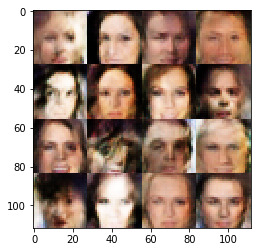

Epoch 1/1... Discriminator Loss: 1.3253... Generator Loss: 0.9754
Epoch 1/1... Discriminator Loss: 1.3086... Generator Loss: 0.9253
Epoch 1/1... Discriminator Loss: 0.9663... Generator Loss: 1.0469
Epoch 1/1... Discriminator Loss: 1.5811... Generator Loss: 1.0641
Epoch 1/1... Discriminator Loss: 1.2836... Generator Loss: 0.9237
Epoch 1/1... Discriminator Loss: 1.3016... Generator Loss: 0.8279
Epoch 1/1... Discriminator Loss: 1.4529... Generator Loss: 1.4305
Epoch 1/1... Discriminator Loss: 1.4249... Generator Loss: 0.8946
Epoch 1/1... Discriminator Loss: 1.2693... Generator Loss: 0.9458
Epoch 1/1... Discriminator Loss: 1.1220... Generator Loss: 0.8929


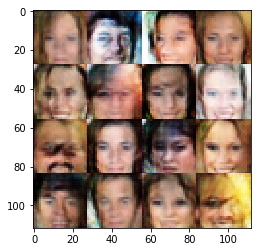

Epoch 1/1... Discriminator Loss: 1.4203... Generator Loss: 0.6764
Epoch 1/1... Discriminator Loss: 1.4276... Generator Loss: 0.9215
Epoch 1/1... Discriminator Loss: 1.3545... Generator Loss: 0.5882
Epoch 1/1... Discriminator Loss: 1.2759... Generator Loss: 0.9917
Epoch 1/1... Discriminator Loss: 1.5828... Generator Loss: 0.8913
Epoch 1/1... Discriminator Loss: 1.3009... Generator Loss: 0.9544
Epoch 1/1... Discriminator Loss: 1.2281... Generator Loss: 1.0285
Epoch 1/1... Discriminator Loss: 1.2921... Generator Loss: 1.1045
Epoch 1/1... Discriminator Loss: 1.1833... Generator Loss: 0.7223
Epoch 1/1... Discriminator Loss: 1.0963... Generator Loss: 0.8036


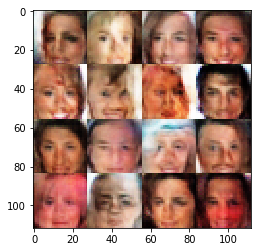

Epoch 1/1... Discriminator Loss: 1.7035... Generator Loss: 0.7428
Epoch 1/1... Discriminator Loss: 1.3817... Generator Loss: 0.9293
Epoch 1/1... Discriminator Loss: 1.4386... Generator Loss: 0.8728
Epoch 1/1... Discriminator Loss: 1.3682... Generator Loss: 0.9228
Epoch 1/1... Discriminator Loss: 1.2677... Generator Loss: 0.8256
Epoch 1/1... Discriminator Loss: 1.0906... Generator Loss: 0.8420
Epoch 1/1... Discriminator Loss: 1.0788... Generator Loss: 0.8177
Epoch 1/1... Discriminator Loss: 1.2423... Generator Loss: 0.7066
Epoch 1/1... Discriminator Loss: 1.4721... Generator Loss: 0.7366
Epoch 1/1... Discriminator Loss: 1.2682... Generator Loss: 0.8312


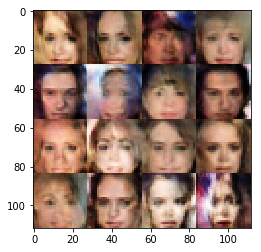

Epoch 1/1... Discriminator Loss: 1.1637... Generator Loss: 0.8389
Epoch 1/1... Discriminator Loss: 1.3000... Generator Loss: 0.8994
Epoch 1/1... Discriminator Loss: 1.1522... Generator Loss: 1.1410
Epoch 1/1... Discriminator Loss: 1.3431... Generator Loss: 0.7993
Epoch 1/1... Discriminator Loss: 1.3857... Generator Loss: 1.2932
Epoch 1/1... Discriminator Loss: 1.4053... Generator Loss: 0.7618
Epoch 1/1... Discriminator Loss: 1.4834... Generator Loss: 0.7285
Epoch 1/1... Discriminator Loss: 1.4231... Generator Loss: 0.5743
Epoch 1/1... Discriminator Loss: 1.4443... Generator Loss: 0.9148
Epoch 1/1... Discriminator Loss: 1.1743... Generator Loss: 1.2456


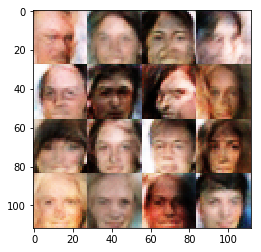

Epoch 1/1... Discriminator Loss: 1.5556... Generator Loss: 0.6622
Epoch 1/1... Discriminator Loss: 1.2980... Generator Loss: 0.9613
Epoch 1/1... Discriminator Loss: 1.3301... Generator Loss: 0.9956
Epoch 1/1... Discriminator Loss: 1.1327... Generator Loss: 0.9233
Epoch 1/1... Discriminator Loss: 1.3568... Generator Loss: 1.0192
Epoch 1/1... Discriminator Loss: 1.3536... Generator Loss: 1.0351
Epoch 1/1... Discriminator Loss: 1.2106... Generator Loss: 1.0565
Epoch 1/1... Discriminator Loss: 1.2059... Generator Loss: 0.8815
Epoch 1/1... Discriminator Loss: 1.1967... Generator Loss: 1.2578
Epoch 1/1... Discriminator Loss: 1.5270... Generator Loss: 0.7781


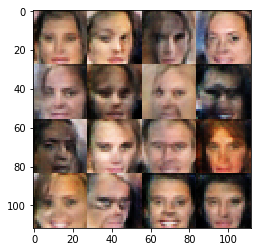

Epoch 1/1... Discriminator Loss: 1.3312... Generator Loss: 0.8039
Epoch 1/1... Discriminator Loss: 1.4704... Generator Loss: 0.5750
Epoch 1/1... Discriminator Loss: 1.0579... Generator Loss: 0.7585
Epoch 1/1... Discriminator Loss: 1.2931... Generator Loss: 1.0680
Epoch 1/1... Discriminator Loss: 1.1732... Generator Loss: 0.7262
Epoch 1/1... Discriminator Loss: 1.2497... Generator Loss: 0.8999
Epoch 1/1... Discriminator Loss: 1.3331... Generator Loss: 0.9369
Epoch 1/1... Discriminator Loss: 0.9842... Generator Loss: 0.9451
Epoch 1/1... Discriminator Loss: 1.8058... Generator Loss: 0.5075
Epoch 1/1... Discriminator Loss: 1.6129... Generator Loss: 0.7933


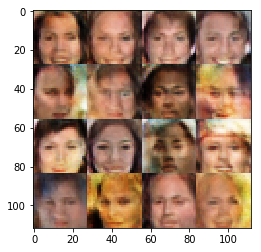

Epoch 1/1... Discriminator Loss: 1.4827... Generator Loss: 0.9098
Epoch 1/1... Discriminator Loss: 1.3742... Generator Loss: 0.9412
Epoch 1/1... Discriminator Loss: 1.3379... Generator Loss: 0.9148
Epoch 1/1... Discriminator Loss: 1.3521... Generator Loss: 0.7928
Epoch 1/1... Discriminator Loss: 1.2616... Generator Loss: 0.9235
Epoch 1/1... Discriminator Loss: 1.1915... Generator Loss: 1.1933
Epoch 1/1... Discriminator Loss: 1.5071... Generator Loss: 0.5958
Epoch 1/1... Discriminator Loss: 1.2579... Generator Loss: 0.7863
Epoch 1/1... Discriminator Loss: 1.4994... Generator Loss: 0.8529
Epoch 1/1... Discriminator Loss: 1.5662... Generator Loss: 0.6686


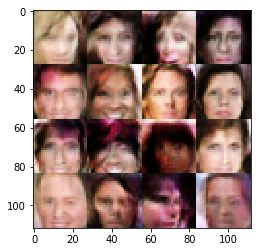

Epoch 1/1... Discriminator Loss: 1.1110... Generator Loss: 0.8647
Epoch 1/1... Discriminator Loss: 1.2031... Generator Loss: 0.9404
Epoch 1/1... Discriminator Loss: 1.2418... Generator Loss: 0.7496
Epoch 1/1... Discriminator Loss: 1.1791... Generator Loss: 0.7127
Epoch 1/1... Discriminator Loss: 1.3306... Generator Loss: 1.1428
Epoch 1/1... Discriminator Loss: 1.0620... Generator Loss: 0.8632
Epoch 1/1... Discriminator Loss: 1.2680... Generator Loss: 0.8748
Epoch 1/1... Discriminator Loss: 1.5489... Generator Loss: 0.7477
Epoch 1/1... Discriminator Loss: 1.3368... Generator Loss: 0.8742
Epoch 1/1... Discriminator Loss: 1.2054... Generator Loss: 0.9254


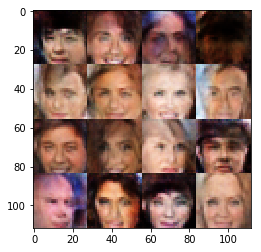

Epoch 1/1... Discriminator Loss: 1.4438... Generator Loss: 0.7951
Epoch 1/1... Discriminator Loss: 1.3376... Generator Loss: 0.9006
Epoch 1/1... Discriminator Loss: 1.4273... Generator Loss: 0.8471
Epoch 1/1... Discriminator Loss: 1.1500... Generator Loss: 0.7278
Epoch 1/1... Discriminator Loss: 1.2602... Generator Loss: 0.8860
Epoch 1/1... Discriminator Loss: 1.3431... Generator Loss: 0.8655
Epoch 1/1... Discriminator Loss: 1.1178... Generator Loss: 0.8651
Epoch 1/1... Discriminator Loss: 1.7388... Generator Loss: 0.6913
Epoch 1/1... Discriminator Loss: 1.2487... Generator Loss: 0.8439
Epoch 1/1... Discriminator Loss: 1.3097... Generator Loss: 0.9246


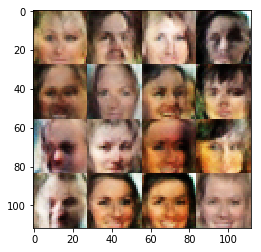

Epoch 1/1... Discriminator Loss: 1.1911... Generator Loss: 1.0267
Epoch 1/1... Discriminator Loss: 1.0585... Generator Loss: 0.6847
Epoch 1/1... Discriminator Loss: 1.4105... Generator Loss: 0.7916
Epoch 1/1... Discriminator Loss: 1.3476... Generator Loss: 1.1911
Epoch 1/1... Discriminator Loss: 1.1568... Generator Loss: 1.0334
Epoch 1/1... Discriminator Loss: 1.4287... Generator Loss: 0.6119
Epoch 1/1... Discriminator Loss: 1.3463... Generator Loss: 0.8047
Epoch 1/1... Discriminator Loss: 1.3135... Generator Loss: 0.6510
Epoch 1/1... Discriminator Loss: 1.2097... Generator Loss: 0.9184
Epoch 1/1... Discriminator Loss: 1.6045... Generator Loss: 0.8261


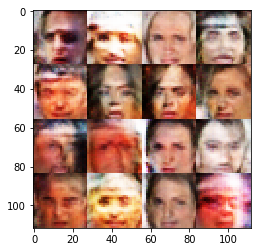

Epoch 1/1... Discriminator Loss: 1.2073... Generator Loss: 0.9655
Epoch 1/1... Discriminator Loss: 1.4162... Generator Loss: 0.6634
Epoch 1/1... Discriminator Loss: 1.3610... Generator Loss: 1.2496
Epoch 1/1... Discriminator Loss: 1.2298... Generator Loss: 0.8736
Epoch 1/1... Discriminator Loss: 1.3923... Generator Loss: 0.6659
Epoch 1/1... Discriminator Loss: 1.2387... Generator Loss: 1.0042
Epoch 1/1... Discriminator Loss: 1.3966... Generator Loss: 1.0048
Epoch 1/1... Discriminator Loss: 1.3209... Generator Loss: 0.8632
Epoch 1/1... Discriminator Loss: 1.3117... Generator Loss: 0.6509
Epoch 1/1... Discriminator Loss: 1.5301... Generator Loss: 0.7134


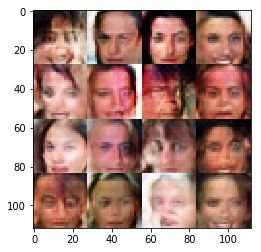

Epoch 1/1... Discriminator Loss: 1.2578... Generator Loss: 1.1721
Epoch 1/1... Discriminator Loss: 1.4081... Generator Loss: 0.8129
Epoch 1/1... Discriminator Loss: 1.3881... Generator Loss: 0.9753
Epoch 1/1... Discriminator Loss: 1.4945... Generator Loss: 1.1581
Epoch 1/1... Discriminator Loss: 1.3458... Generator Loss: 0.6892
Epoch 1/1... Discriminator Loss: 1.2442... Generator Loss: 0.9152
Epoch 1/1... Discriminator Loss: 1.1972... Generator Loss: 1.1491
Epoch 1/1... Discriminator Loss: 1.4858... Generator Loss: 0.8656
Epoch 1/1... Discriminator Loss: 1.4212... Generator Loss: 0.8949
Epoch 1/1... Discriminator Loss: 1.2234... Generator Loss: 0.9071


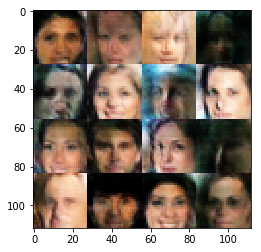

Epoch 1/1... Discriminator Loss: 1.3307... Generator Loss: 0.5821
Epoch 1/1... Discriminator Loss: 1.5380... Generator Loss: 0.9730
Epoch 1/1... Discriminator Loss: 1.2991... Generator Loss: 0.8630
Epoch 1/1... Discriminator Loss: 1.2598... Generator Loss: 1.0464
Epoch 1/1... Discriminator Loss: 1.3279... Generator Loss: 0.8834
Epoch 1/1... Discriminator Loss: 1.4785... Generator Loss: 0.7852
Epoch 1/1... Discriminator Loss: 1.1436... Generator Loss: 1.0416
Epoch 1/1... Discriminator Loss: 1.3819... Generator Loss: 0.5752
Epoch 1/1... Discriminator Loss: 1.4094... Generator Loss: 0.7227
Epoch 1/1... Discriminator Loss: 1.3714... Generator Loss: 0.8987


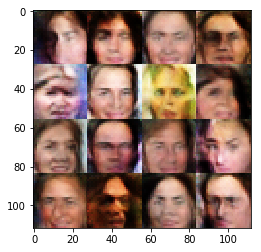

Epoch 1/1... Discriminator Loss: 1.2270... Generator Loss: 1.5760
Epoch 1/1... Discriminator Loss: 1.2887... Generator Loss: 0.7424
Epoch 1/1... Discriminator Loss: 1.0253... Generator Loss: 0.7904
Epoch 1/1... Discriminator Loss: 1.3981... Generator Loss: 0.8217
Epoch 1/1... Discriminator Loss: 1.4313... Generator Loss: 0.8475
Epoch 1/1... Discriminator Loss: 1.4870... Generator Loss: 0.7785
Epoch 1/1... Discriminator Loss: 1.2070... Generator Loss: 0.9212
Epoch 1/1... Discriminator Loss: 1.6787... Generator Loss: 1.1510
Epoch 1/1... Discriminator Loss: 1.2376... Generator Loss: 1.0115
Epoch 1/1... Discriminator Loss: 1.2424... Generator Loss: 1.0030


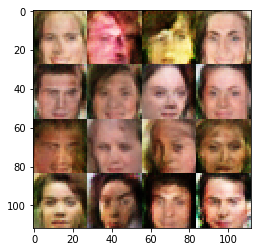

Epoch 1/1... Discriminator Loss: 1.5579... Generator Loss: 0.9069
Epoch 1/1... Discriminator Loss: 1.3148... Generator Loss: 0.9887
Epoch 1/1... Discriminator Loss: 1.3756... Generator Loss: 0.7799
Epoch 1/1... Discriminator Loss: 1.2247... Generator Loss: 1.0137
Epoch 1/1... Discriminator Loss: 1.3356... Generator Loss: 0.8482
Epoch 1/1... Discriminator Loss: 1.7288... Generator Loss: 1.1065
Epoch 1/1... Discriminator Loss: 1.5410... Generator Loss: 0.5535
Epoch 1/1... Discriminator Loss: 0.9877... Generator Loss: 0.8053
Epoch 1/1... Discriminator Loss: 1.2202... Generator Loss: 0.7665
Epoch 1/1... Discriminator Loss: 1.3091... Generator Loss: 0.7583


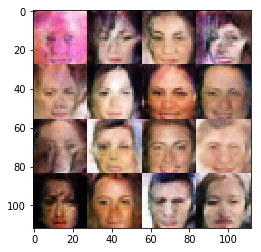

Epoch 1/1... Discriminator Loss: 1.5280... Generator Loss: 0.9309
Epoch 1/1... Discriminator Loss: 1.3329... Generator Loss: 0.9926
Epoch 1/1... Discriminator Loss: 1.2253... Generator Loss: 1.2200
Epoch 1/1... Discriminator Loss: 1.2483... Generator Loss: 0.8764
Epoch 1/1... Discriminator Loss: 1.3124... Generator Loss: 1.0563
Epoch 1/1... Discriminator Loss: 1.4397... Generator Loss: 0.8401
Epoch 1/1... Discriminator Loss: 1.4187... Generator Loss: 0.7574
Epoch 1/1... Discriminator Loss: 1.3423... Generator Loss: 0.9702
Epoch 1/1... Discriminator Loss: 1.3544... Generator Loss: 0.7871
Epoch 1/1... Discriminator Loss: 1.1433... Generator Loss: 0.8036


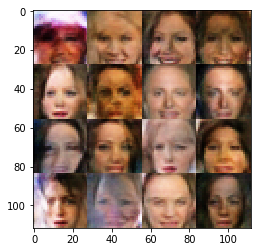

Epoch 1/1... Discriminator Loss: 1.5089... Generator Loss: 0.6922
Epoch 1/1... Discriminator Loss: 1.3324... Generator Loss: 1.1332
Epoch 1/1... Discriminator Loss: 1.4730... Generator Loss: 0.8190
Epoch 1/1... Discriminator Loss: 1.3575... Generator Loss: 0.8556
Epoch 1/1... Discriminator Loss: 1.1609... Generator Loss: 0.7859
Epoch 1/1... Discriminator Loss: 1.3409... Generator Loss: 0.8474
Epoch 1/1... Discriminator Loss: 1.4118... Generator Loss: 0.8899
Epoch 1/1... Discriminator Loss: 1.4667... Generator Loss: 0.6809
Epoch 1/1... Discriminator Loss: 1.2724... Generator Loss: 1.0274
Epoch 1/1... Discriminator Loss: 1.5576... Generator Loss: 0.6460


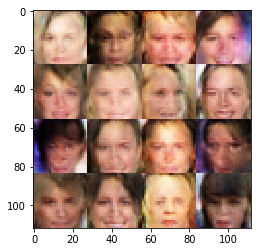

Epoch 1/1... Discriminator Loss: 1.5570... Generator Loss: 0.8687
Epoch 1/1... Discriminator Loss: 1.2222... Generator Loss: 0.9702
Epoch 1/1... Discriminator Loss: 1.7159... Generator Loss: 0.6370
Epoch 1/1... Discriminator Loss: 1.1176... Generator Loss: 1.0292
Epoch 1/1... Discriminator Loss: 1.1277... Generator Loss: 1.0296
Epoch 1/1... Discriminator Loss: 0.9896... Generator Loss: 1.0104
Epoch 1/1... Discriminator Loss: 1.2047... Generator Loss: 0.7519
Epoch 1/1... Discriminator Loss: 1.5553... Generator Loss: 0.8294
Epoch 1/1... Discriminator Loss: 1.2038... Generator Loss: 1.0121
Epoch 1/1... Discriminator Loss: 1.2359... Generator Loss: 0.7329


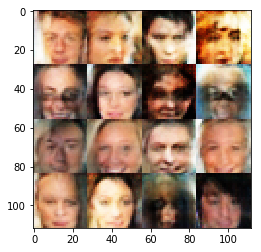

Epoch 1/1... Discriminator Loss: 1.2811... Generator Loss: 1.1059
Epoch 1/1... Discriminator Loss: 1.5024... Generator Loss: 0.6644
Epoch 1/1... Discriminator Loss: 1.3782... Generator Loss: 0.7660
Epoch 1/1... Discriminator Loss: 1.4839... Generator Loss: 0.8260
Epoch 1/1... Discriminator Loss: 1.7091... Generator Loss: 0.6764
Epoch 1/1... Discriminator Loss: 1.2183... Generator Loss: 1.1093


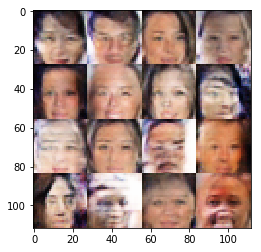

Done


In [12]:
batch_size = 16
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.